In [1]:
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from os import path
from utils import *

import pandas as pd

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [20, 10]
plt.style.use('fivethirtyeight')
import random


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np

from glob import glob
import os
from scipy.signal import resample


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# training parameters
seed=42

dr=0.2
lr2=1e-4
lr1=1e-4
lr=8e-4

num_epochs=5000
mini_batch_size=4

main_units=128
secondary_units=64
last_unit=32
lstm_units=128
num_classes=1

today="20220908"

print_sample=False

In [3]:
files = glob('/data/elekin/data/results/fmri/preproc/cbl/*/cbl_extracted_ts_{}.csv'.format(today))
data = []
for file in files:
    df = pd.read_csv(file, header=None)
    data.append(df.values)
features = np.array(data)
features.shape

(105, 158, 28)

In [4]:
flatten_features = features.reshape(features.shape[0], features.shape[1]*features.shape[2])
flatten_features.shape

(105, 4424)

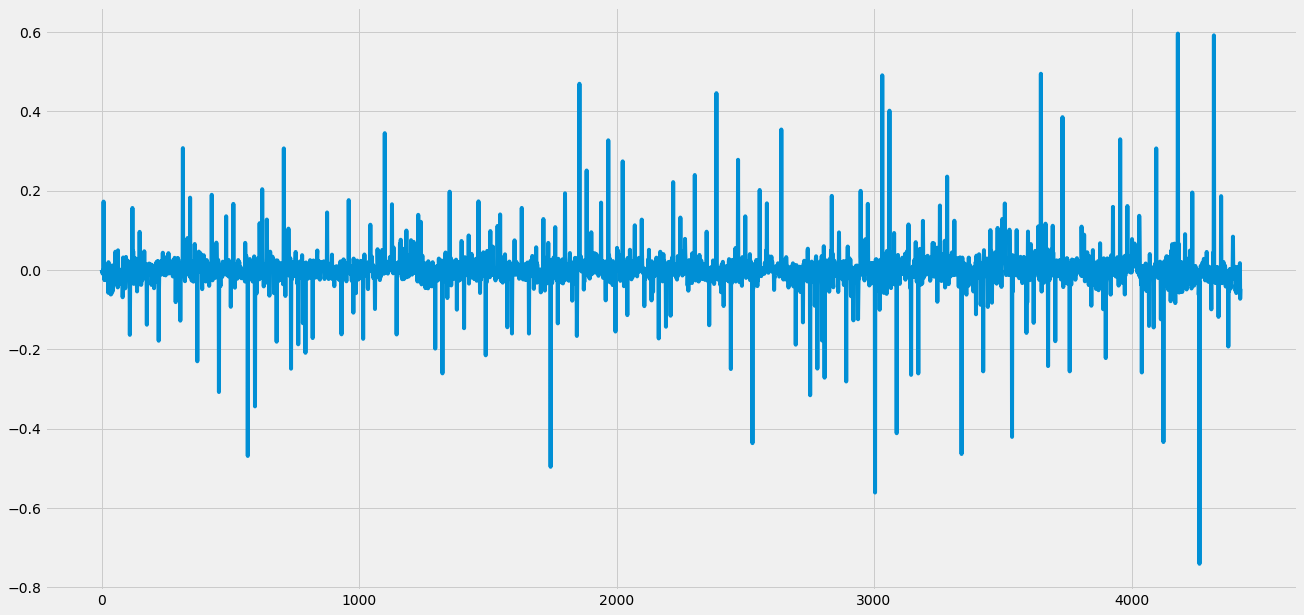

In [5]:
plt.style.use('fivethirtyeight')

idx = random.randint(0,105)
_=plt.plot(flatten_features[0])

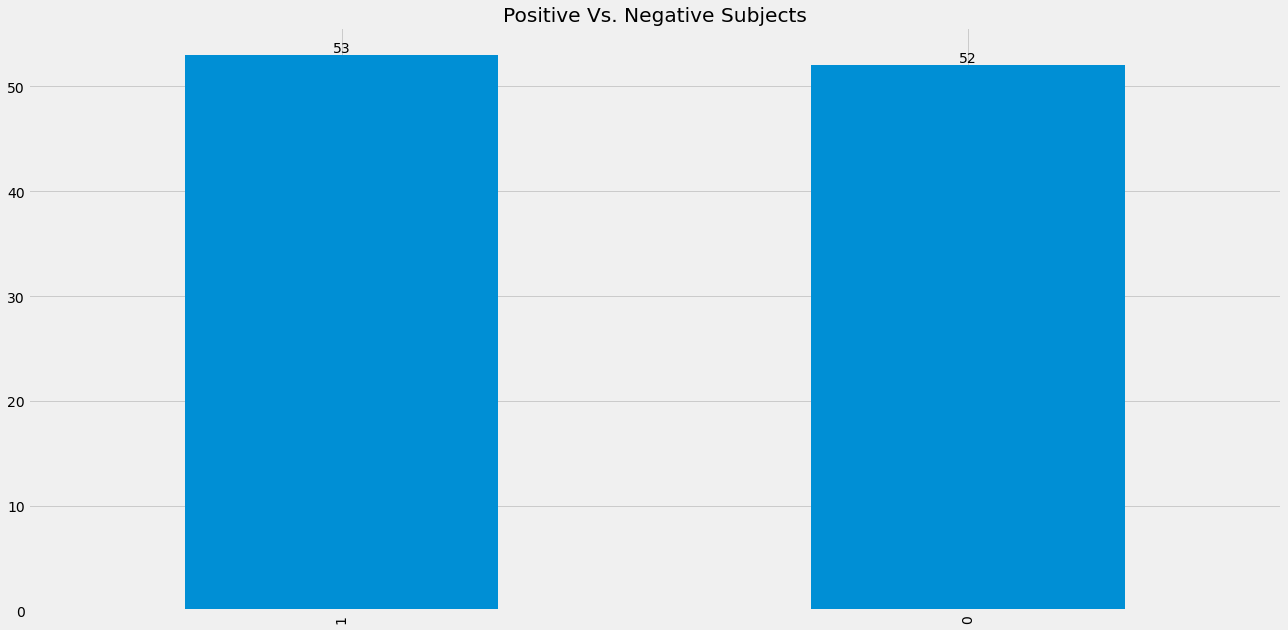

In [6]:
levels = pd.read_csv('/data/elekin/data/results/fmri/preproc/cbl/cbl_levels_{}.csv'.format(today),index_col=0)
levels.sample(5)
labels = (levels.Level > 0).astype(np.int16)
ax = labels.value_counts().plot.bar(title='Positive Vs. Negative Subjects', x='counts')
_ = ax.bar_label(ax.containers[0])

In [7]:
from sklearn import preprocessing
#multi labels
#lb = preprocessing.LabelBinarizer()
#y = lb.fit_transform(labels).astype(np.int16)
#y.shape
#binary labels
le = LabelEncoder().fit(labels.values.ravel())
y = le.fit_transform(labels.values.ravel()).astype(np.int16)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int16)

In [8]:
X = flatten_features.astype(np.float32)
X.shape

(105, 4424)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [10]:
x_train.shape, x_test.shape

((70, 4424), (35, 4424))

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).take(len(x_train)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(len(x_test)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
steps_per_epoch = round(len(train_dataset)/mini_batch_size)

if print_sample:
    for feat, targ in test_dataset.take(10):
        print ('Features test: {}, Target: {}'.format(feat, targ))

    for feat, targ in test_dataset.take(10):
        print ('Features train: {}, Target: {}'.format(feat, targ))

print("{0} train batches and {1} test batches of {2} mini batch size and {3} steps per epoch".format(len(train_dataset), 
                                                                              len(test_dataset),
                                                                              mini_batch_size,
                                                                                steps_per_epoch))

18 train batches and 9 test batches of 4 mini batch size and 4 steps per epoch


## FCNN ARCHITECTURE ANALISYS

Some training helpers functions

In [12]:
def get_callbacks(name):
    return [
        #tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, min_delta=1e-4),
        #tf.keras.callbacks.TensorBoard(logdir/name),
      ]

def compile_and_fit(model, train_dataset, test_dataset, name, optimizer=None, max_epochs=1000):
    tf.keras.backend.clear_session()# avoid clutter from old models and layers, especially when memory is limited
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    tf.random.set_seed(seed) # establecemos la semilla para tensorflow
    history = model.fit(train_dataset, 
                        use_multiprocessing=True, 
                        validation_data=test_dataset, epochs=max_epochs, 
                        callbacks=get_callbacks(name),
                        verbose=1, shuffle=False)
    return history

# Many models train better if you gradually reduce the learning rate during training. 
# Use optimizers.schedules to reduce the learning rate over time:
def get_optimizer(steps_per_epoch=1, lr=1e-4, multiplier=1000):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(lr,
                                                                 decay_steps=steps_per_epoch*multiplier,
                                                                 decay_rate=1,
                                                                 staircase=False)
    return tf.keras.optimizers.Adam(lr_schedule)

In [13]:
size_histories = {}

In [14]:
num_features = x_train.shape[1]
tiny = tf.keras.models.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)])

size_histories['fcnn/tiny'] = compile_and_fit(tiny, train_dataset, 
                                              test_dataset,
                                              "fcnn/tiny", 
#                                               optimizer=get_optimizer(),
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/tiny'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/tiny'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               566400    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 566,529
Trainable params: 566,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5000
18/18 [==============================] - 1s 6ms/step - loss: 0.6881 - accuracy: 0.5143 - val_loss: 0.6949 - val_accuracy: 0.5429
Epoch 2/5000
18/18 [==============================] - 0s 2ms/step - loss: 0.4769 - accuracy: 1.0000 - val_loss: 0.6948 - val_accuracy: 0.5429
Epoch 3/5000
18/18 [==============================] - 0s 2ms/step - loss: 0.3635 - accuracy: 1.0000 - val_loss: 0.6970 - val_accuracy: 0.5143
Epoch 4/5000
18/18 [

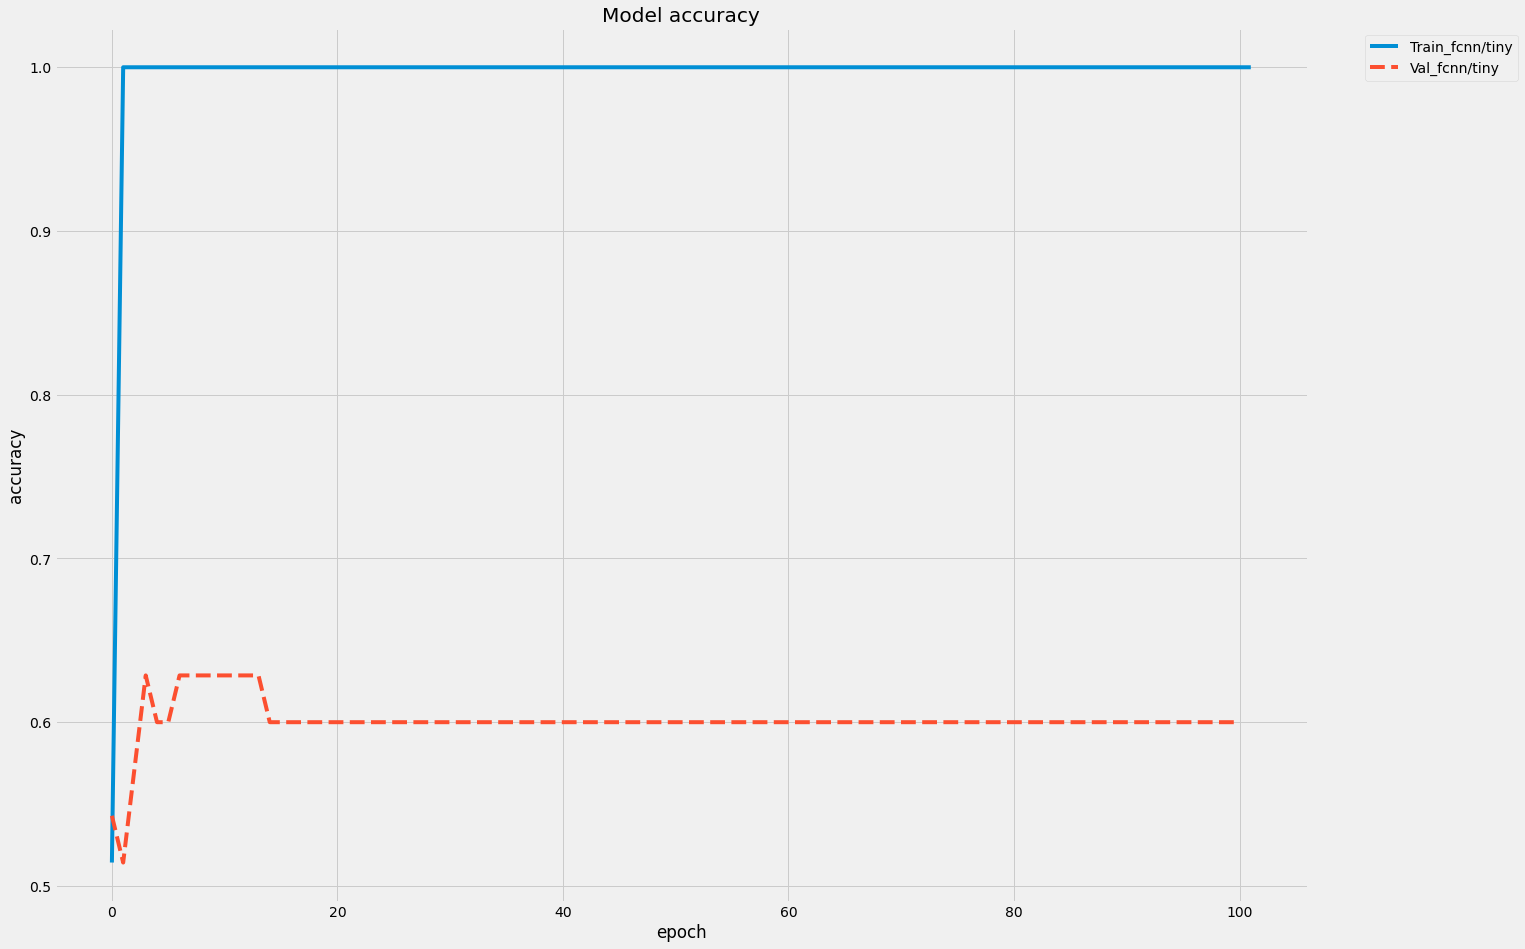

In [15]:
plt.rcParams['figure.figsize'] = [20.0, 15.0]
plot_report(size_histories, metric='accuracy')

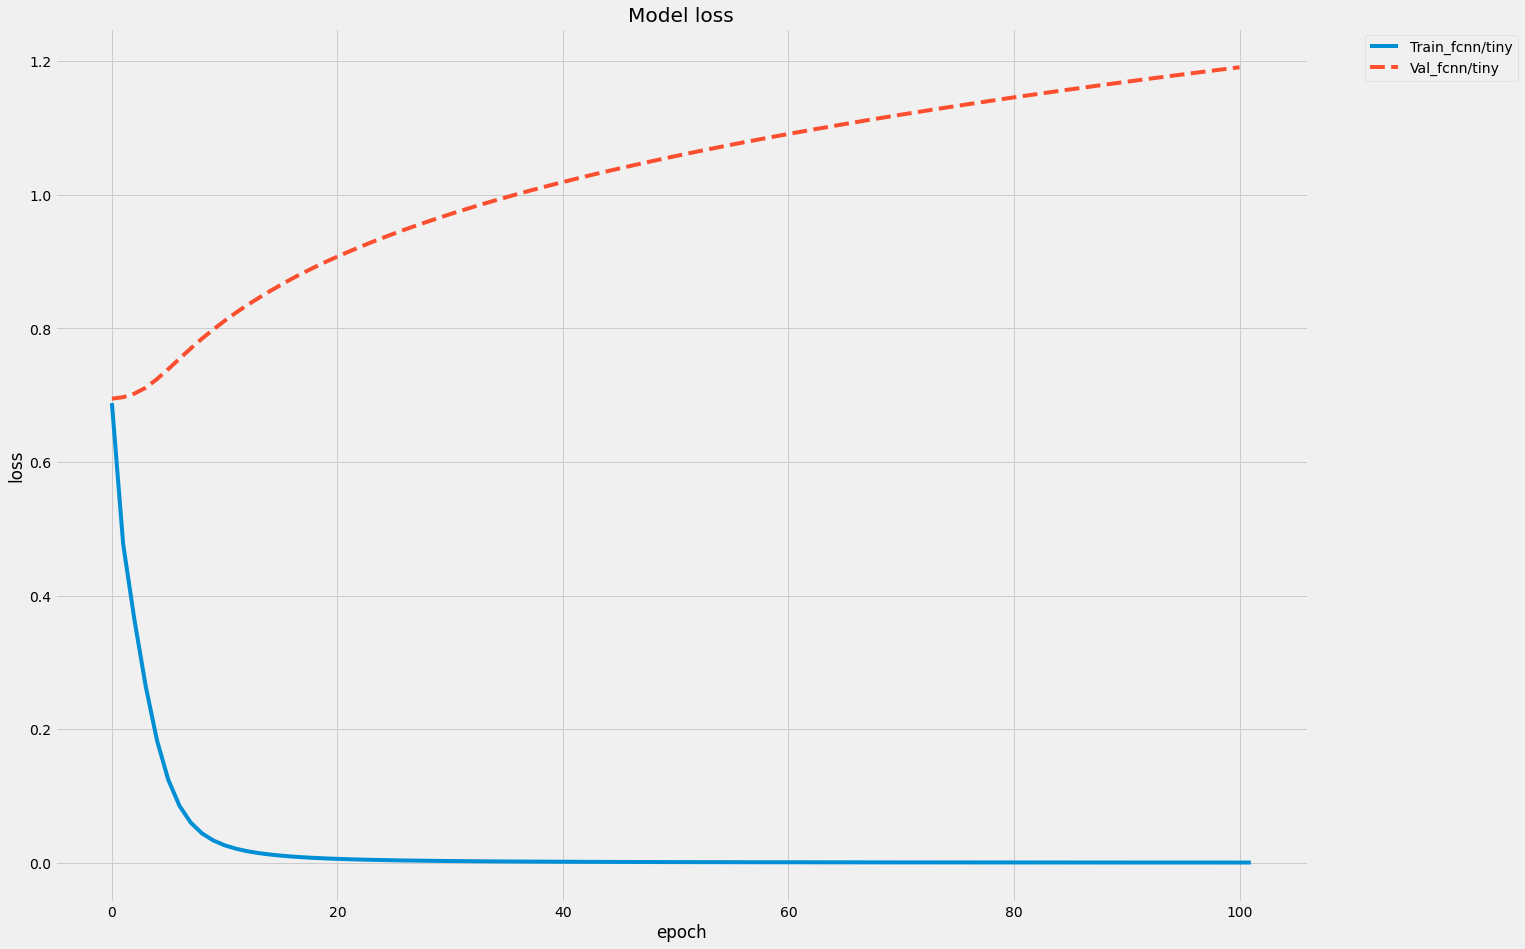

In [16]:
plot_report(size_histories, 'loss')

In [17]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/small'] = compile_and_fit(small_model, train_dataset, 
                                              test_dataset,'fcnn/small',
#                                               optimizer=get_optimizer(),
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/small'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/small'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               566400    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 574,721
Trainable params: 574,721
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5000
18/18 [==============================] - 0s 5ms/step - loss: 0.6988 - accuracy: 0.4714 - val_loss: 0.6892 - val_accuracy: 0.4857
Epoch 2/5000
18/18 [==============================] - 0s 2ms/step - loss: 0.5449 - accuracy: 1.0000 - val_loss: 0.6883 - val_accuracy: 0.4857
Epoch 3/5000
18/18 [==========

Epoch 52/5000
18/18 [==============================] - 0s 2ms/step - loss: 1.4029e-04 - accuracy: 1.0000 - val_loss: 1.3047 - val_accuracy: 0.6000
Epoch 53/5000
18/18 [==============================] - 0s 2ms/step - loss: 1.3480e-04 - accuracy: 1.0000 - val_loss: 1.3088 - val_accuracy: 0.6000
Epoch 54/5000
18/18 [==============================] - 0s 2ms/step - loss: 1.2960e-04 - accuracy: 1.0000 - val_loss: 1.3129 - val_accuracy: 0.6000
Epoch 55/5000
18/18 [==============================] - 0s 2ms/step - loss: 1.2470e-04 - accuracy: 1.0000 - val_loss: 1.3169 - val_accuracy: 0.6000
Epoch 56/5000
18/18 [==============================] - 0s 2ms/step - loss: 1.2006e-04 - accuracy: 1.0000 - val_loss: 1.3208 - val_accuracy: 0.6000
Epoch 57/5000
18/18 [==============================] - 0s 2ms/step - loss: 1.1567e-04 - accuracy: 1.0000 - val_loss: 1.3247 - val_accuracy: 0.6000
Epoch 58/5000
18/18 [==============================] - 0s 2ms/step - loss: 1.1150e-04 - accuracy: 1.0000 - val_loss: 1

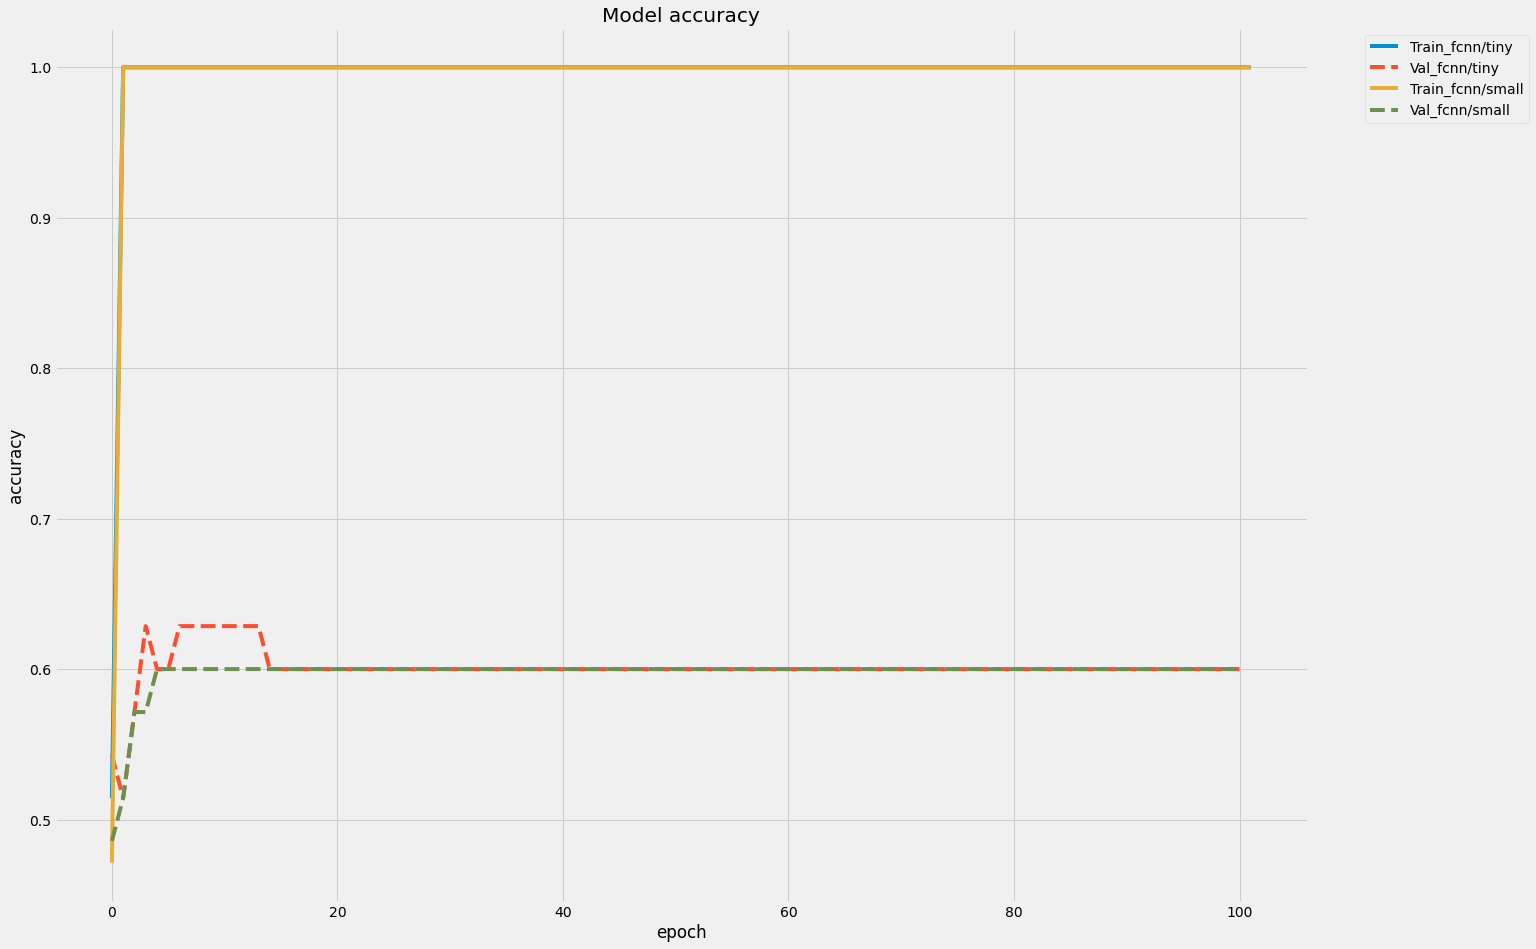

In [18]:
plot_report(size_histories)

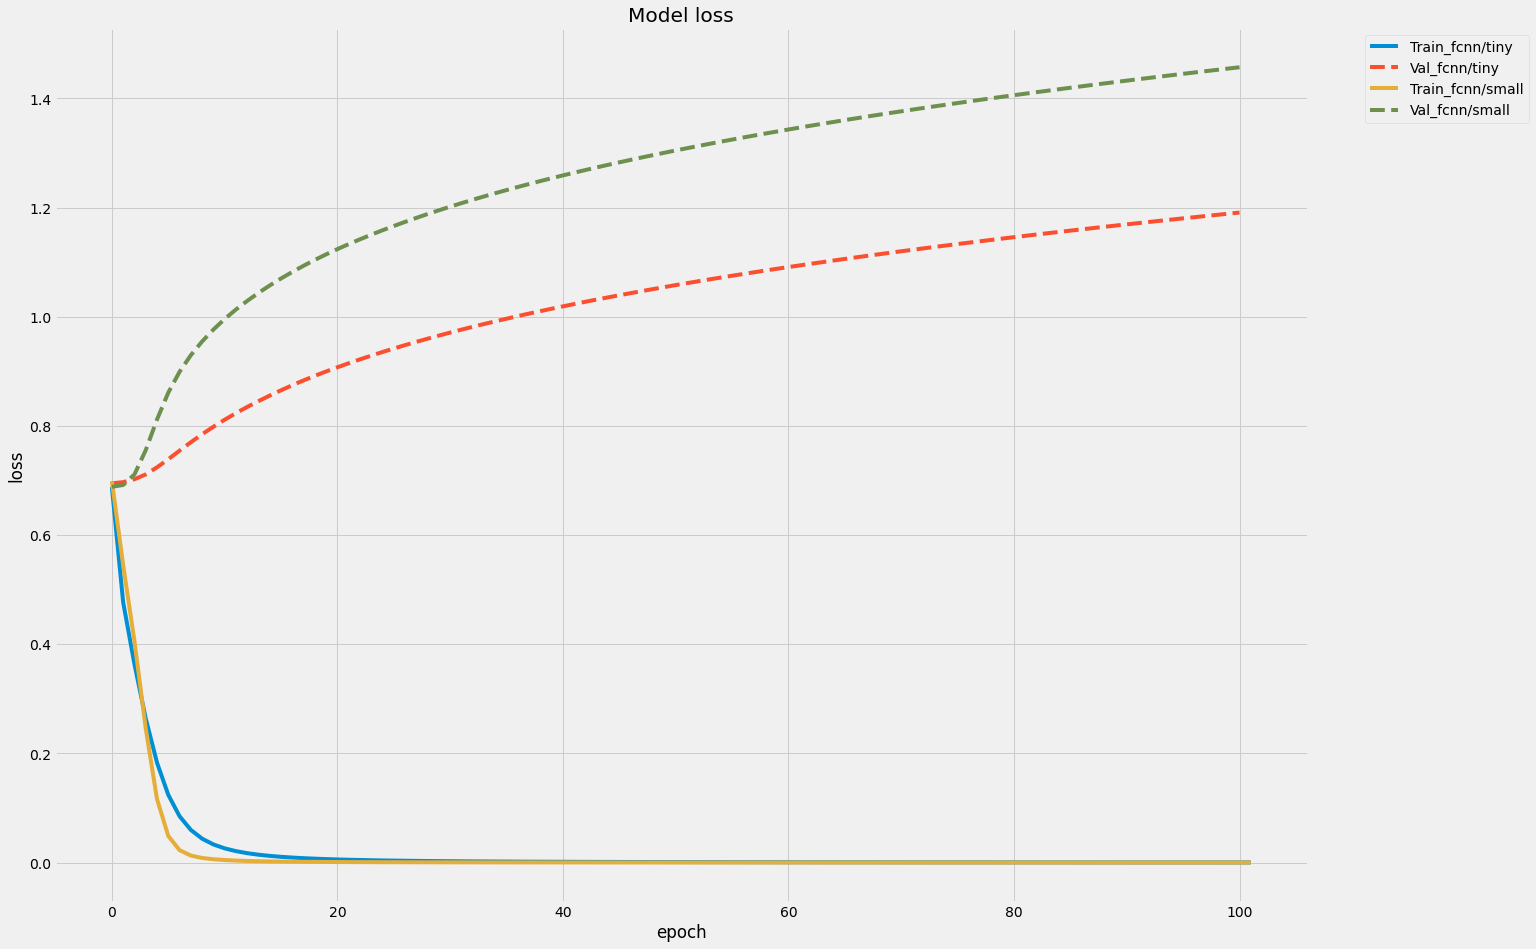

In [19]:
plot_report(size_histories, 'loss')

In [20]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),  
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/large'] = compile_and_fit(large_model, train_dataset, 
                                              test_dataset, "fcnn/large",
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer=get_optimizer(), 
                                              max_epochs=num_epochs)

print("Evaluation")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/large'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/large'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               566400    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 593,281
Trainable params: 593,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5000
18/18 [==============================

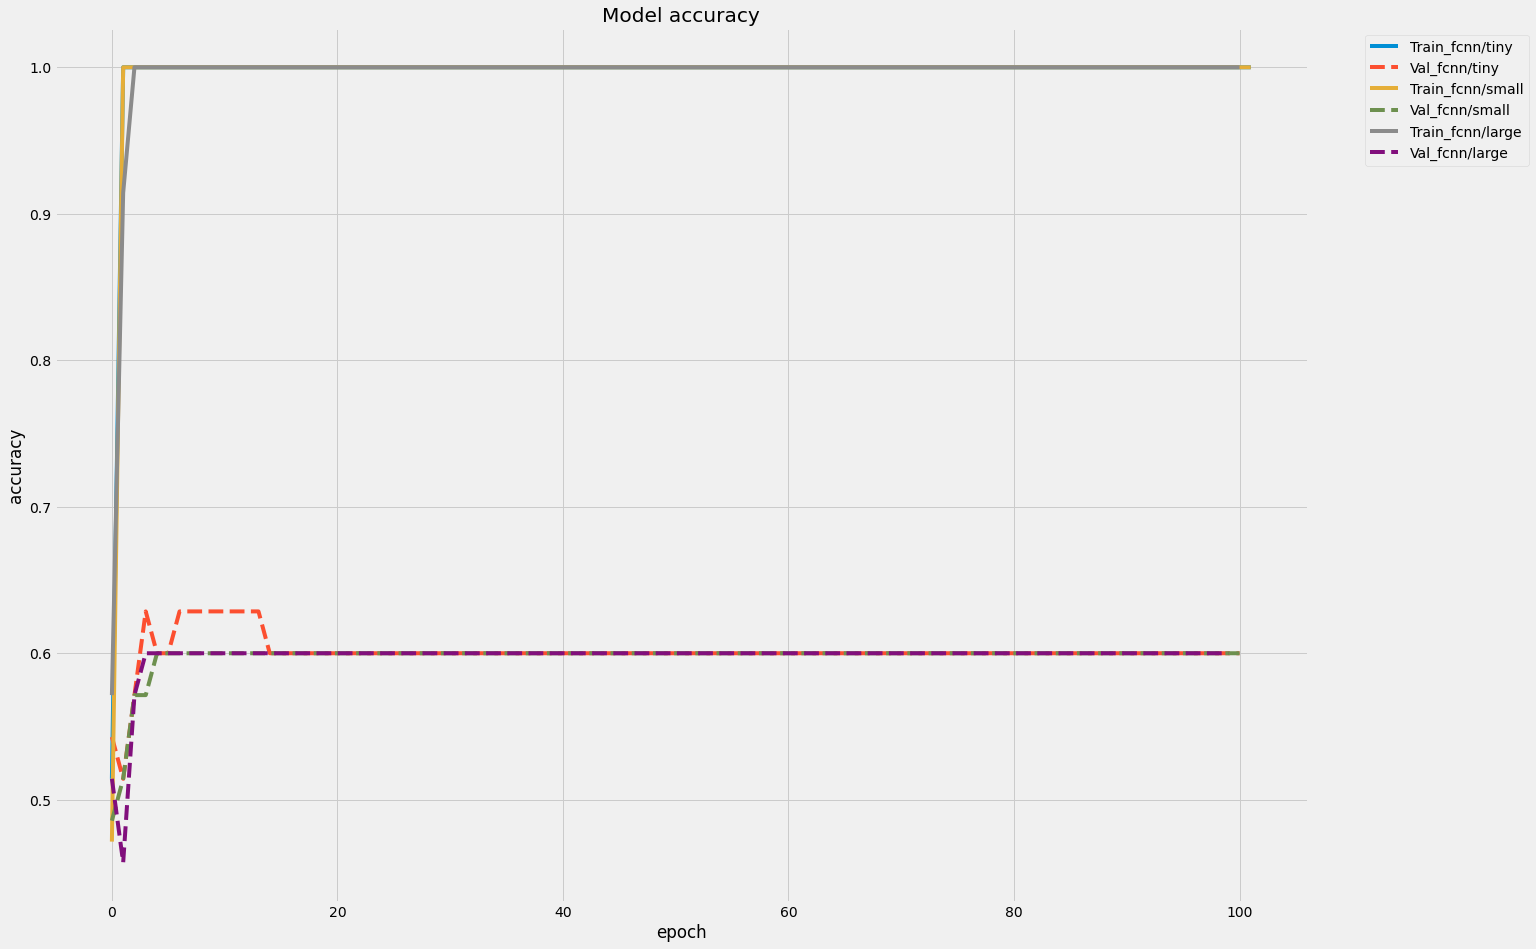

In [21]:
plot_report(size_histories)

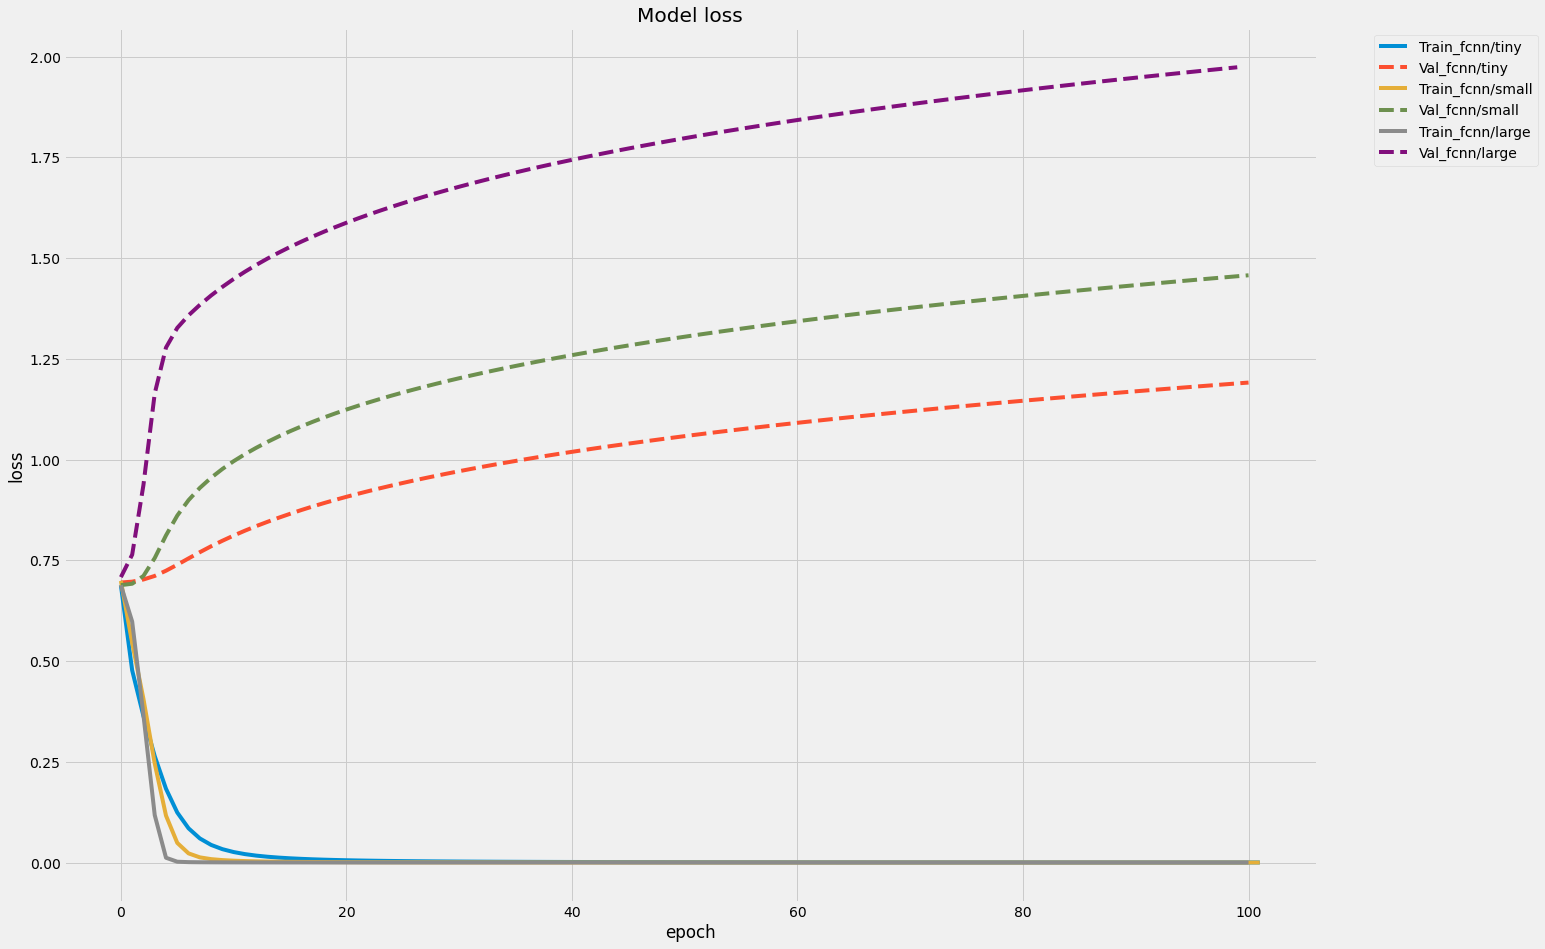

In [22]:
plot_report(size_histories, 'loss')

### Dropout

Although we got an accuracy of 0.75 looking at loss function chart is pretty obvious: There is overfiting. Now we have an overfitted NN let's make some adjustments to improve generalization capacity startin from dropout techniques.  

In [23]:
tiny_dropout = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/tiny/dropout'] = compile_and_fit(tiny_dropout, 
                                                      train_dataset,
                                                      test_dataset,
                                                      "fcnn/tiny/dropout", 
                                                      optimizer=tf.keras.optimizers.Adam(lr), 
                                                      max_epochs=num_epochs)

print("\n#######################EVALUATIO######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/tiny/dropout'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/tiny/dropout'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               566400    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 3

Epoch 48/5000
18/18 [==============================] - 0s 2ms/step - loss: 6.4695e-05 - accuracy: 1.0000 - val_loss: 1.9882 - val_accuracy: 0.6000
Epoch 49/5000
18/18 [==============================] - 0s 2ms/step - loss: 2.2610e-04 - accuracy: 1.0000 - val_loss: 2.0112 - val_accuracy: 0.6000
Epoch 50/5000
18/18 [==============================] - 0s 2ms/step - loss: 6.1138e-05 - accuracy: 1.0000 - val_loss: 2.0278 - val_accuracy: 0.6000
Epoch 51/5000
18/18 [==============================] - 0s 2ms/step - loss: 6.2850e-05 - accuracy: 1.0000 - val_loss: 2.0364 - val_accuracy: 0.6000
Epoch 52/5000
18/18 [==============================] - 0s 2ms/step - loss: 2.9374e-05 - accuracy: 1.0000 - val_loss: 2.0431 - val_accuracy: 0.6000
Epoch 53/5000
18/18 [==============================] - 0s 2ms/step - loss: 9.5438e-05 - accuracy: 1.0000 - val_loss: 2.0550 - val_accuracy: 0.6000
Epoch 54/5000
18/18 [==============================] - 0s 2ms/step - loss: 1.8450e-05 - accuracy: 1.0000 - val_loss: 2

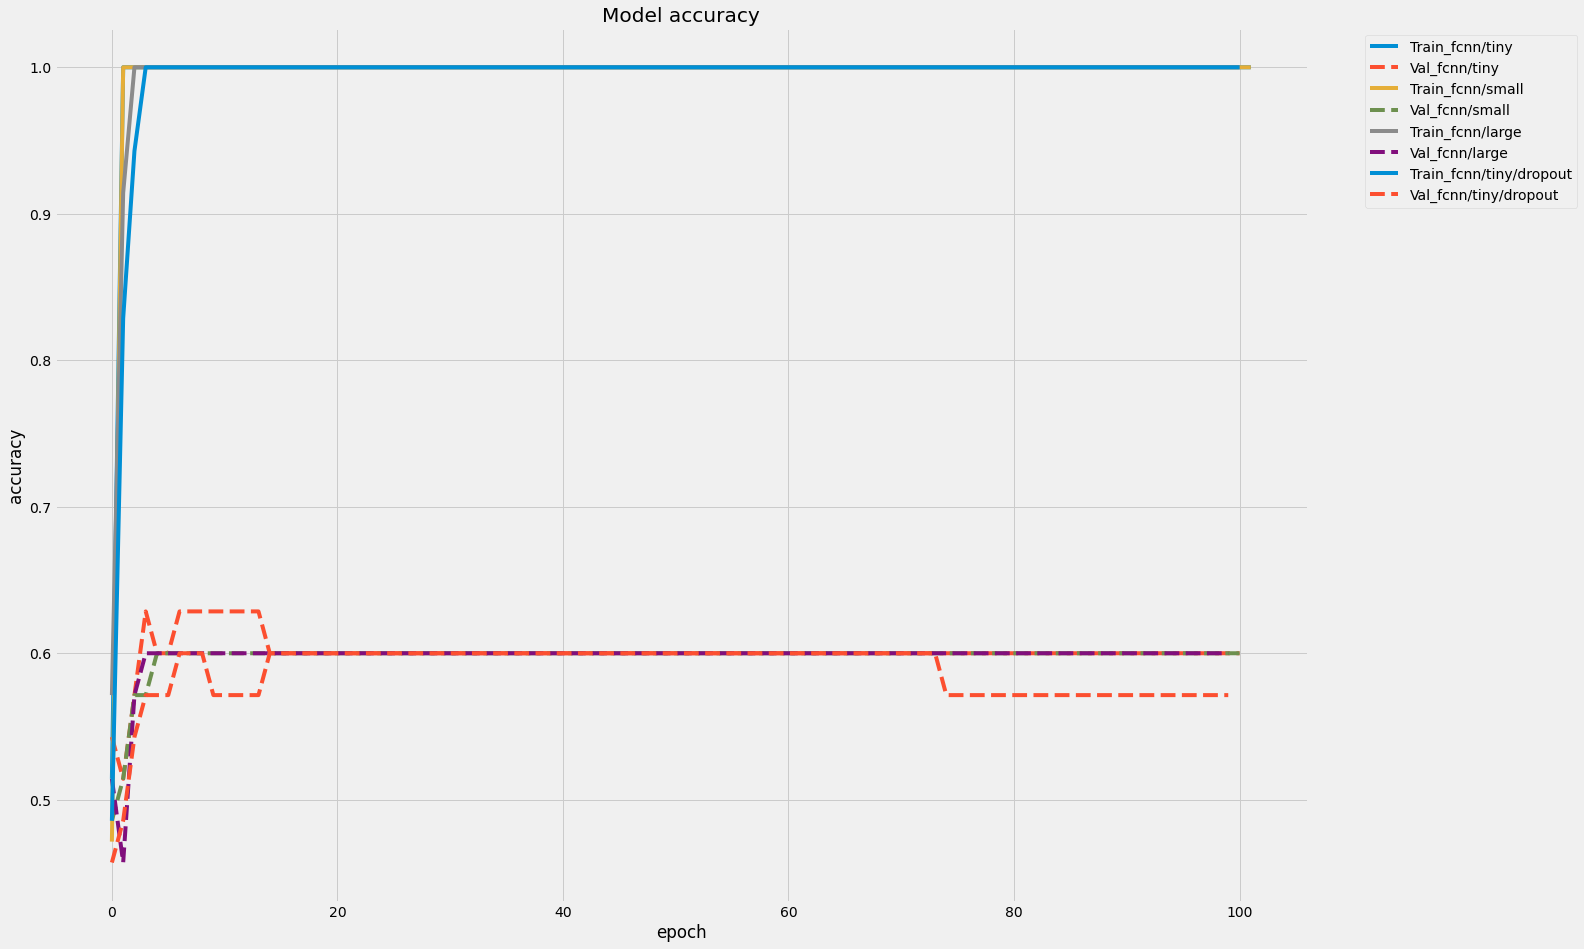

In [24]:
plot_report(size_histories)

Validation accuracy keeps improving more epoch with a total improvement from 0.75 to 0.81. Furthemore, the gap between training loss function and test loss function has been reduced.

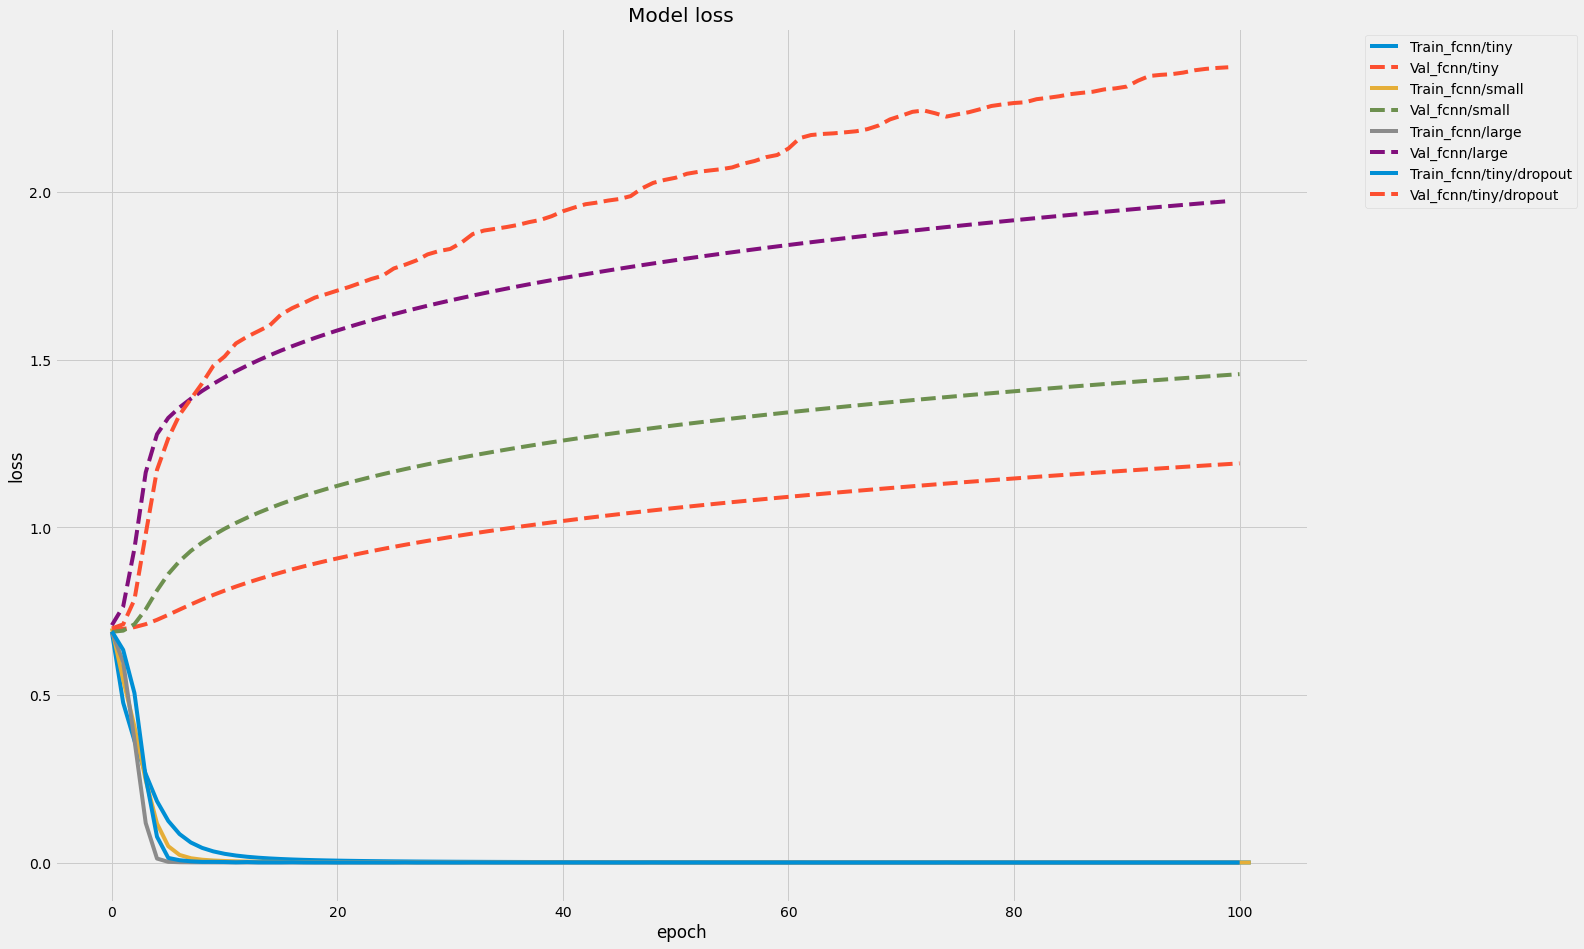

In [25]:
plot_report(size_histories, metric='loss')

### Kernel regularizer

In [26]:
# shutil.rmtree(logdir/'regularizers/tiny', ignore_errors=True)
# shutil.copytree(logdir/'fcnn/tiny', logdir/'regularizers/tiny')
regularizer_histories = {}
regularizer_histories['large'] = size_histories['fcnn/large']
regularizer_histories['dropout'] = size_histories['fcnn/tiny/dropout']

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.

In tf.keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [27]:
l2_model = tf.keras.Sequential([
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1),
                 input_shape=(num_features,)),
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(secondary_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(last_unit, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
regularizer_histories['l2'] = compile_and_fit(l2_model, train_dataset, 
                                              test_dataset, 
                                              optimizer=tf.keras.optimizers.Adam(lr),
                                              name="regularizers/l2")
# Evaluate the model on the test data using `evaluate`
print("\n#######################EVALUATIO######################")
print('train acc:', max(regularizer_histories['l2'].history["accuracy"]))
print('test acc:', max(regularizer_histories['l2'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               566400    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 593,281
Trainable params: 593,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
18/18 [==============================

Epoch 51/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.0456 - accuracy: 1.0000 - val_loss: 2.3612 - val_accuracy: 0.4857
Epoch 52/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.0446 - accuracy: 1.0000 - val_loss: 2.3577 - val_accuracy: 0.4857
Epoch 53/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.0437 - accuracy: 1.0000 - val_loss: 2.3647 - val_accuracy: 0.4857
Epoch 54/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.0430 - accuracy: 1.0000 - val_loss: 2.3707 - val_accuracy: 0.4857
Epoch 55/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.0421 - accuracy: 1.0000 - val_loss: 2.3705 - val_accuracy: 0.4857
Epoch 56/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.0413 - accuracy: 1.0000 - val_loss: 2.3632 - val_accuracy: 0.4857
Epoch 57/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.0406 - accuracy: 1.0000 - val_loss: 2.3629 - val_accuracy: 0.4857

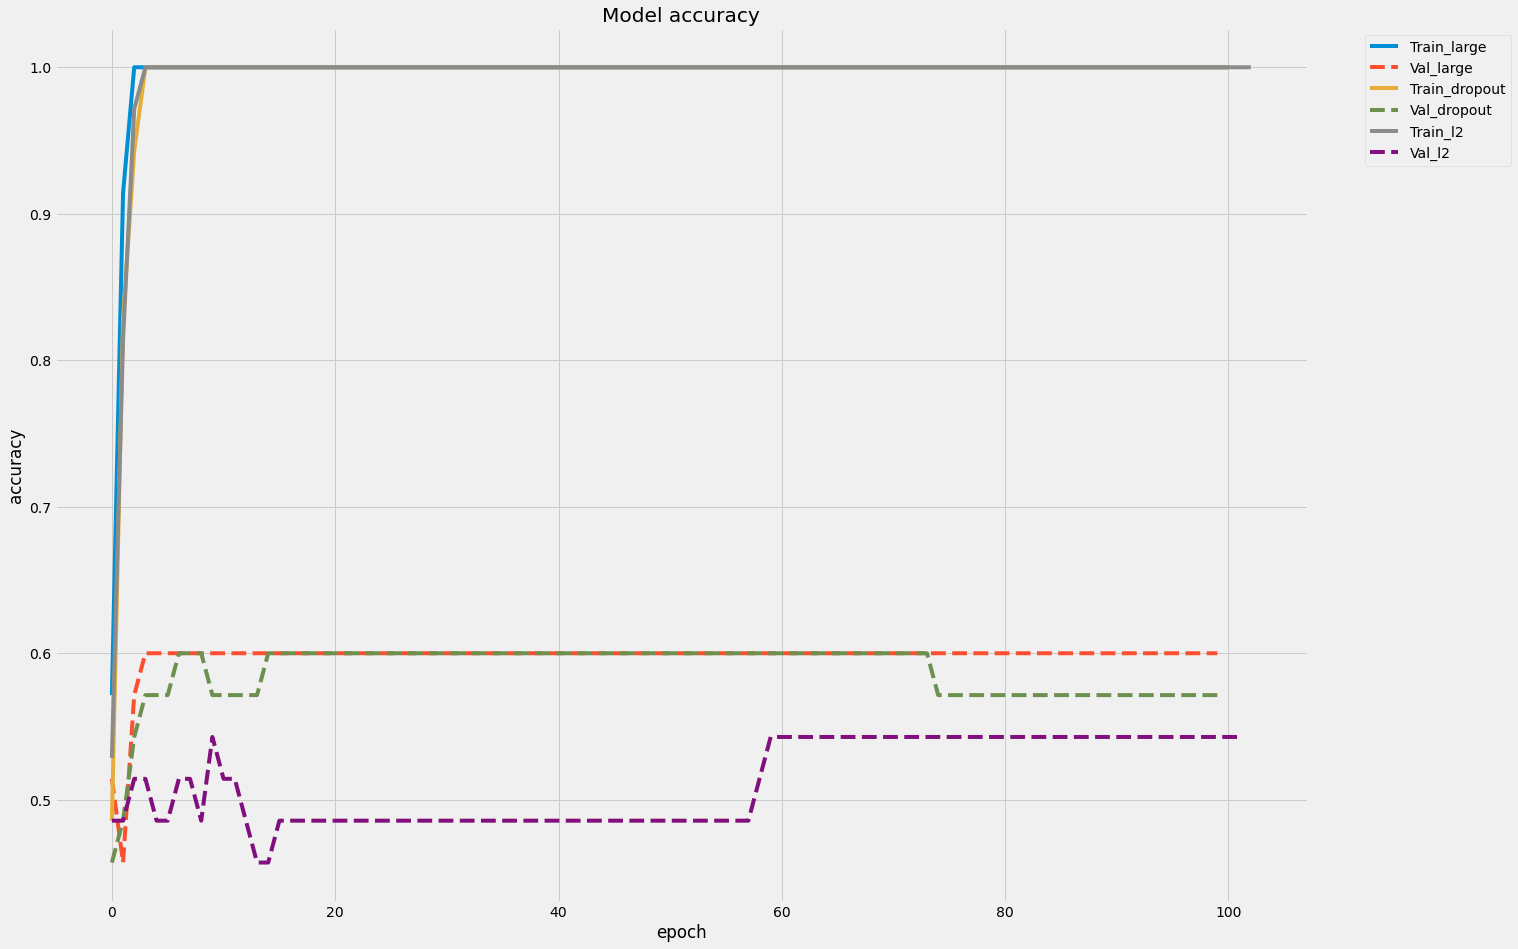

In [28]:
plot_report(regularizer_histories, 'accuracy')

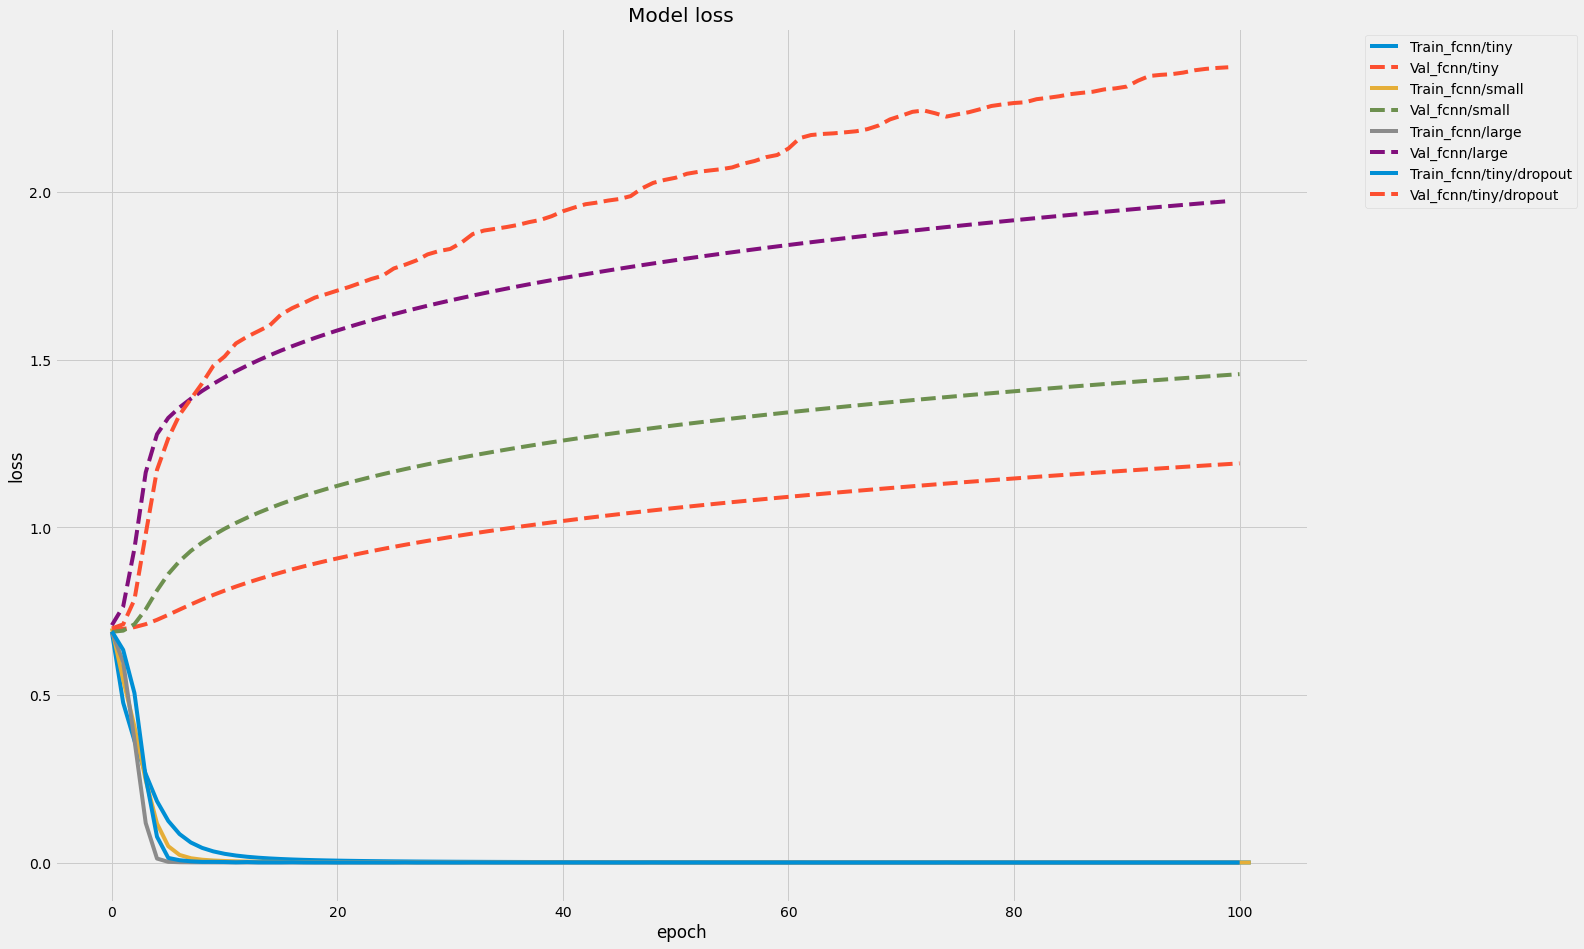

In [29]:
plot_report(size_histories, 'loss')

Now let's see what happens combining both techniques

In [30]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
combined_model = tf.keras.Sequential([
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1),
                 input_shape=(num_features,)),
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(secondary_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(last_unit, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    tf.keras.layers.Dropout(dr),
    layers.Dense(num_classes, activation=tf.nn.sigmoid)
])

tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
regularizer_histories['combined'] = compile_and_fit(combined_model, train_dataset, test_dataset, "regularizers/combined",
                                                   optimizer=get_optimizer())

# Evaluate the model on the test data using `evaluate`
print()
print('train acc:', max(regularizer_histories['combined'].history["accuracy"]))
print('test acc:', max(regularizer_histories['combined'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               566400    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 593,281
Trainable params: 593,281
Non-trai

Epoch 50/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.3755 - accuracy: 1.0000 - val_loss: 1.4795 - val_accuracy: 0.4857
Epoch 51/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.3688 - accuracy: 1.0000 - val_loss: 1.4840 - val_accuracy: 0.4857
Epoch 52/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.3657 - accuracy: 1.0000 - val_loss: 1.4884 - val_accuracy: 0.4857
Epoch 53/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.3570 - accuracy: 1.0000 - val_loss: 1.4920 - val_accuracy: 0.4857
Epoch 54/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.3500 - accuracy: 1.0000 - val_loss: 1.4947 - val_accuracy: 0.4857
Epoch 55/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.3493 - accuracy: 1.0000 - val_loss: 1.5005 - val_accuracy: 0.4857
Epoch 56/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.3418 - accuracy: 1.0000 - val_loss: 1.5041 - val_accuracy: 0.4857

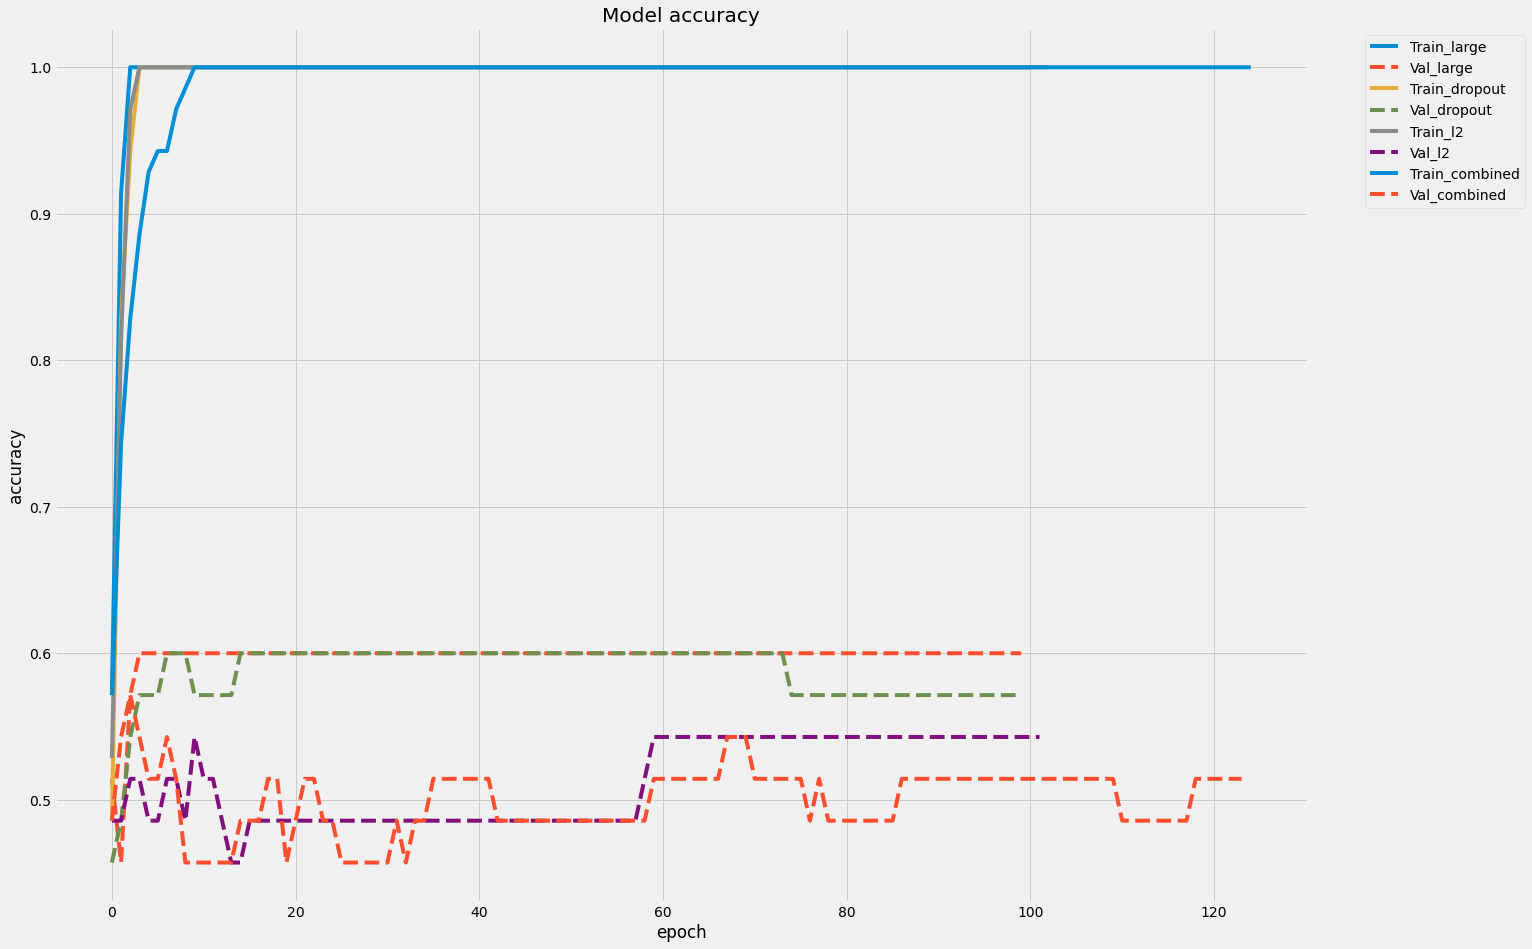

In [31]:
plot_report(regularizer_histories, 'accuracy')

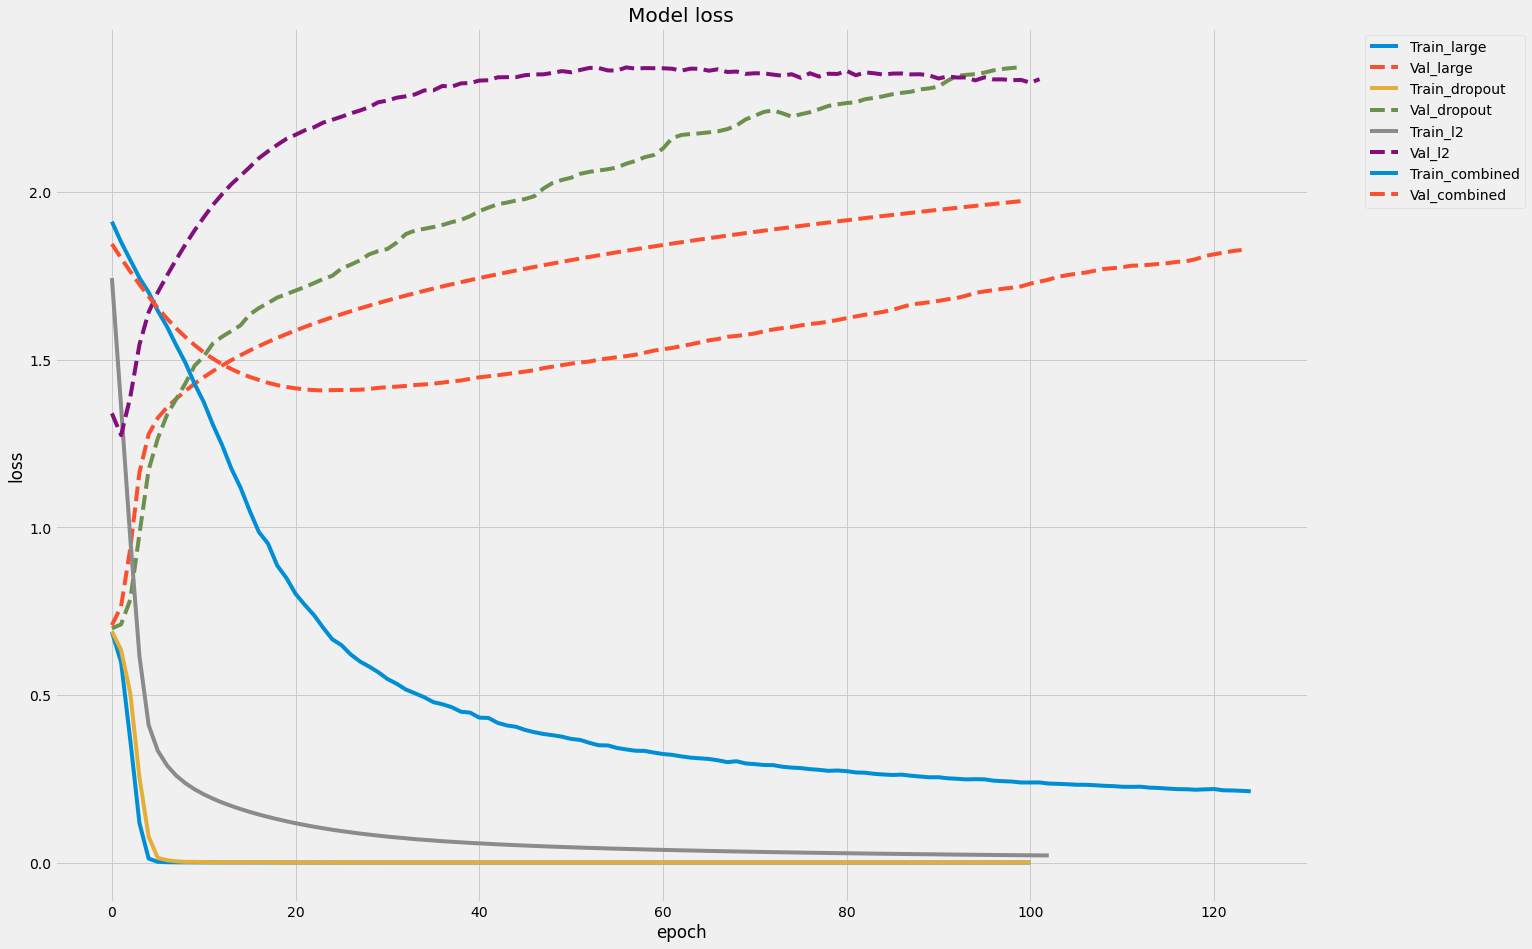

In [32]:
plot_report(regularizer_histories, 'loss')

## Batch Normalization

Batch normalization (also known as batch norm) is a method used to make artificial neural networks faster and more stable through normalization of the input layer by re-centering and re-scaling. It was proposed by Sergey Ioffe and Christian Szegedy in 2015.

[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

[Tensorflow implementation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)


In [33]:
batch_histories = {}
batch_histories['large'] = size_histories['fcnn/large']
batch_histories['dropout'] = size_histories['fcnn/tiny/dropout']

In [34]:
small_batch = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
batch_histories['fcnn/small/batch'] = compile_and_fit(small_batch, 
                                                      train_dataset,
                                                      test_dataset,
                                                      "fcnn/small/batch", 
                                                      optimizer=tf.keras.optimizers.Adam(lr), 
                                                      max_epochs=num_epochs)

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(batch_histories['fcnn/small/batch'].history["accuracy"]))
print('test acc:', max(batch_histories['fcnn/small/batch'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               566400    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               2

18/18 [==============================] - 0s 3ms/step - loss: 0.0368 - accuracy: 0.9857 - val_loss: 1.8974 - val_accuracy: 0.5429
Epoch 102/5000
18/18 [==============================] - 0s 3ms/step - loss: 0.0518 - accuracy: 0.9714 - val_loss: 1.9242 - val_accuracy: 0.5429
Epoch 103/5000
18/18 [==============================] - 0s 3ms/step - loss: 0.0407 - accuracy: 0.9714 - val_loss: 1.9359 - val_accuracy: 0.5429
Epoch 104/5000
18/18 [==============================] - 0s 3ms/step - loss: 0.0488 - accuracy: 0.9857 - val_loss: 1.9547 - val_accuracy: 0.5429
Epoch 105/5000
18/18 [==============================] - 0s 3ms/step - loss: 0.0248 - accuracy: 1.0000 - val_loss: 1.9604 - val_accuracy: 0.5429
Epoch 106/5000
18/18 [==============================] - 0s 3ms/step - loss: 0.0341 - accuracy: 1.0000 - val_loss: 1.9759 - val_accuracy: 0.5429
Epoch 107/5000
18/18 [==============================] - 0s 3ms/step - loss: 0.0455 - accuracy: 0.9857 - val_loss: 1.9913 - val_accuracy: 0.5429

######

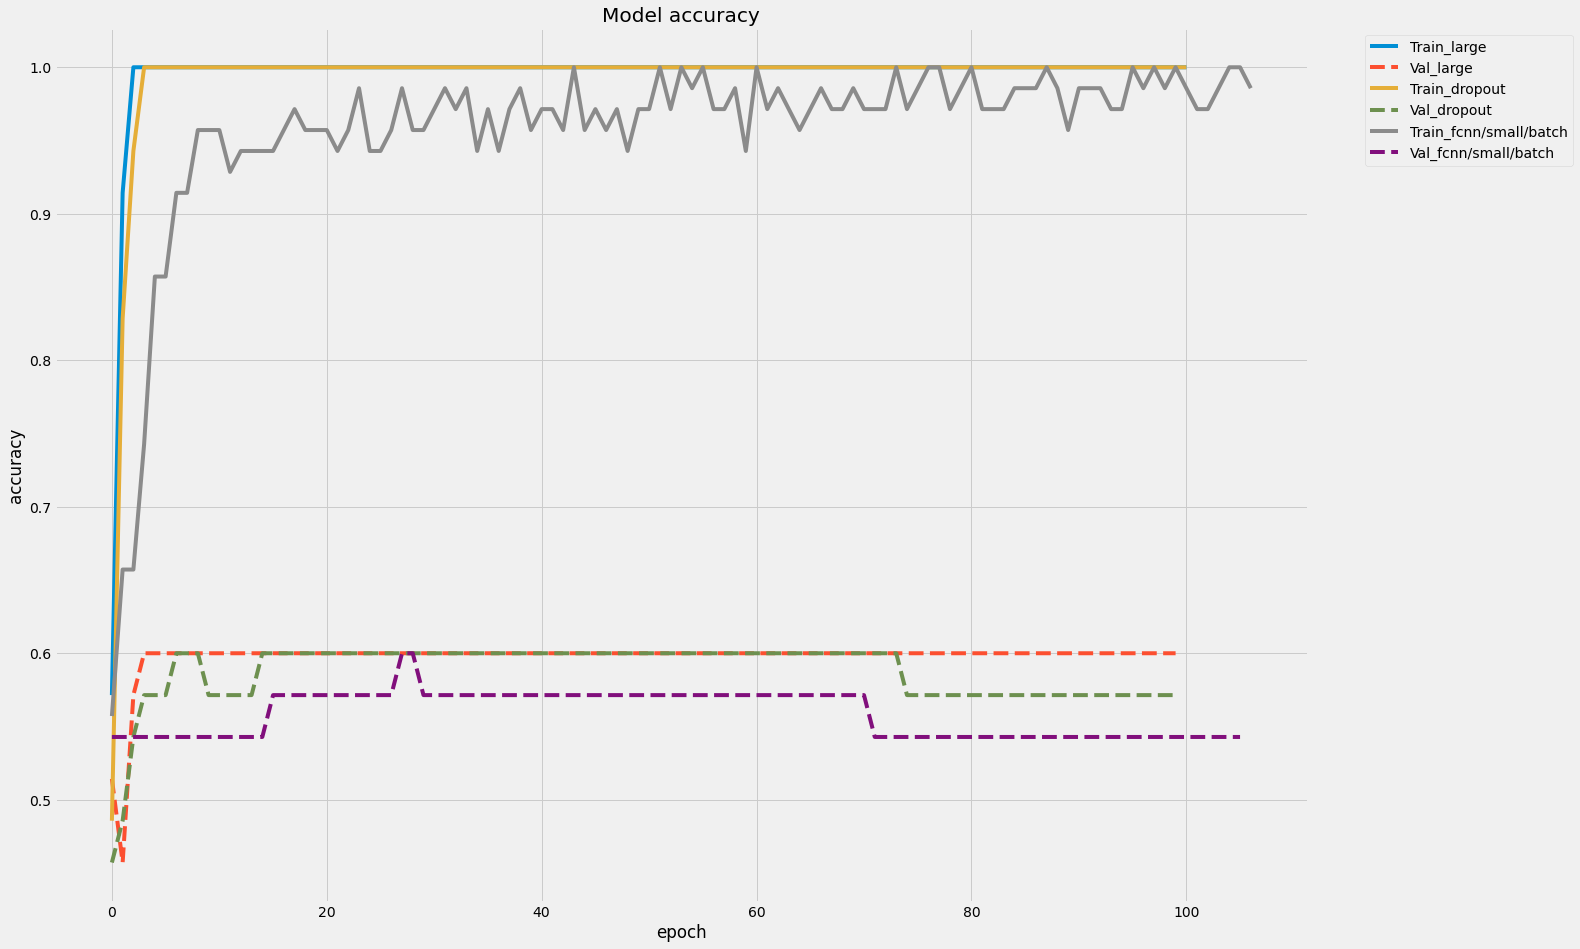

In [35]:
plot_report(batch_histories, 'accuracy')

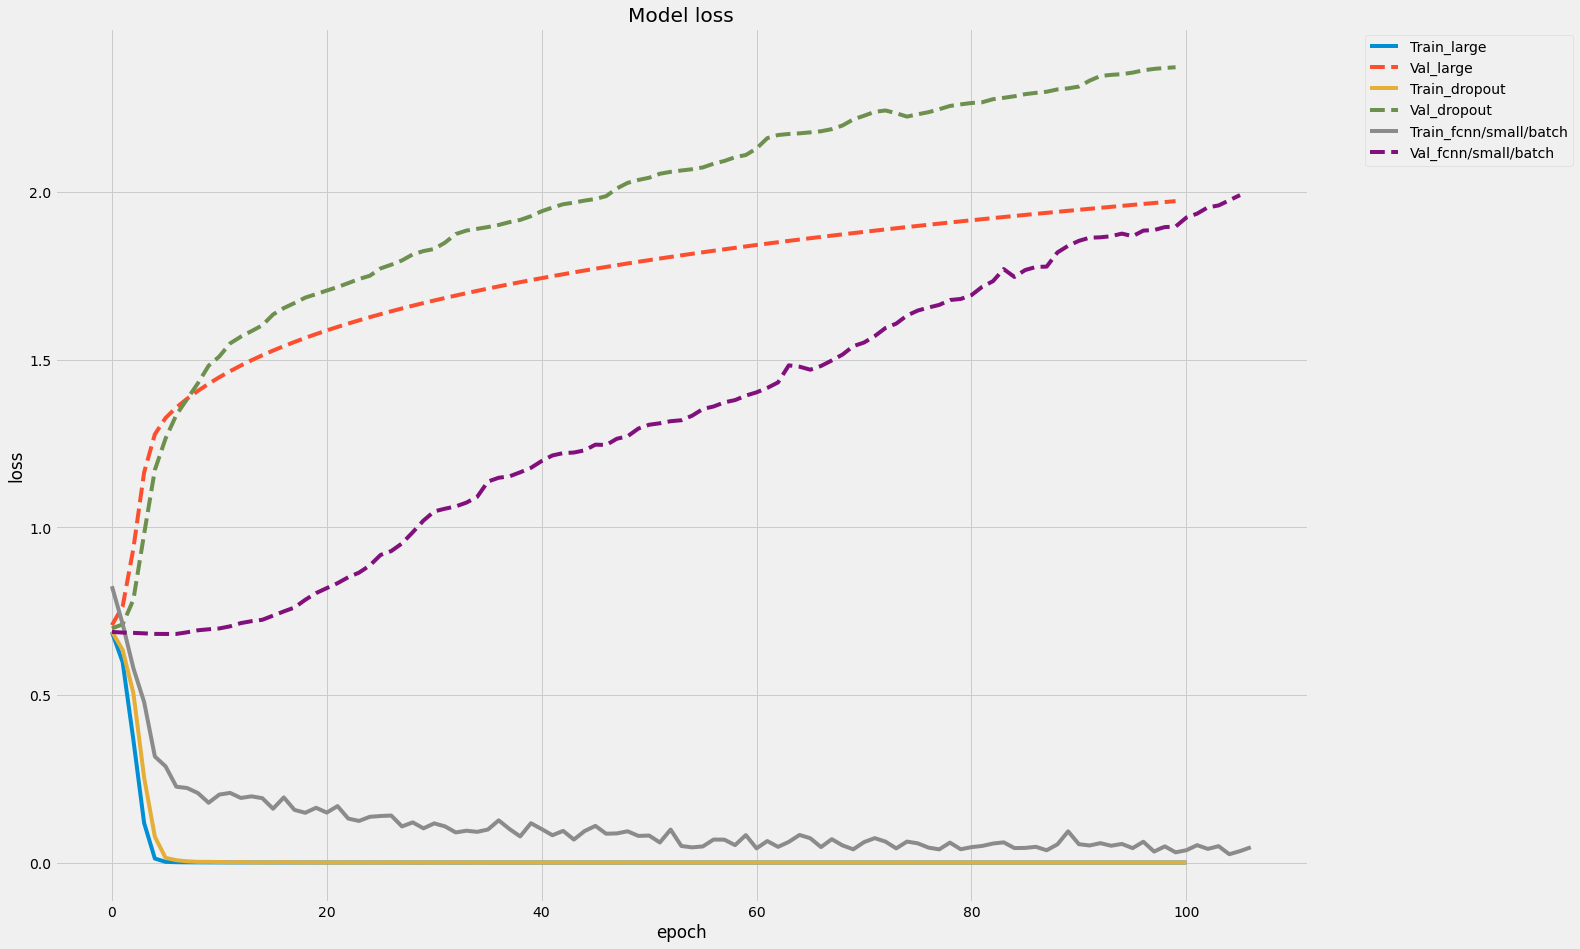

In [36]:
plot_report(batch_histories, 'loss')

## LSTM-FCNN

Univariate time series classification model, the Long Short Term Memory Fully Convolutional Network (LSTM-FCN) to capture time related information

In [37]:
X = features
X.shape

(105, 158, 28)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).take(len(x_train)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(len(x_test)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
steps_per_epoch = round(len(train_dataset)/mini_batch_size)

In [39]:
lstm_histories = {}
#lstm_histories['large'] = size_histories['fcnn/large']
#lstm_histories['dropout'] = size_histories['fcnn/tiny/dropout']

In [40]:
lstm_units=128
lstm_tiny_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2),
                         input_shape=[X.shape[1],X.shape[2],]
                        ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
#     tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/tiny'] = compile_and_fit(lstm_tiny_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                                        lr=1e-4,
#                                                                        multiplier=10),
                                               name="lstm/tiny")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/tiny'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/tiny'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               80384     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 85,057
Trainable params: 84,801
Non-trainable params: 256
_________________________________________________________________
Epoch 1/1000
18/18 [==============================] - 2s 23ms/step - loss: 0.7105 - accuracy: 0.5286 - val_loss: 0.6

18/18 [==============================] - 0s 7ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 2.7971 - val_accuracy: 0.4857
Epoch 109/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 2.4707 - val_accuracy: 0.5143
Epoch 110/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 2.2526 - val_accuracy: 0.5429
Epoch 111/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 2.2586 - val_accuracy: 0.5143
Epoch 112/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 2.4976 - val_accuracy: 0.6000
Epoch 113/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 2.6609 - val_accuracy: 0.6000

#######################EVALUATION######################
train acc: 1.0
test acc: 0.6571428775787354


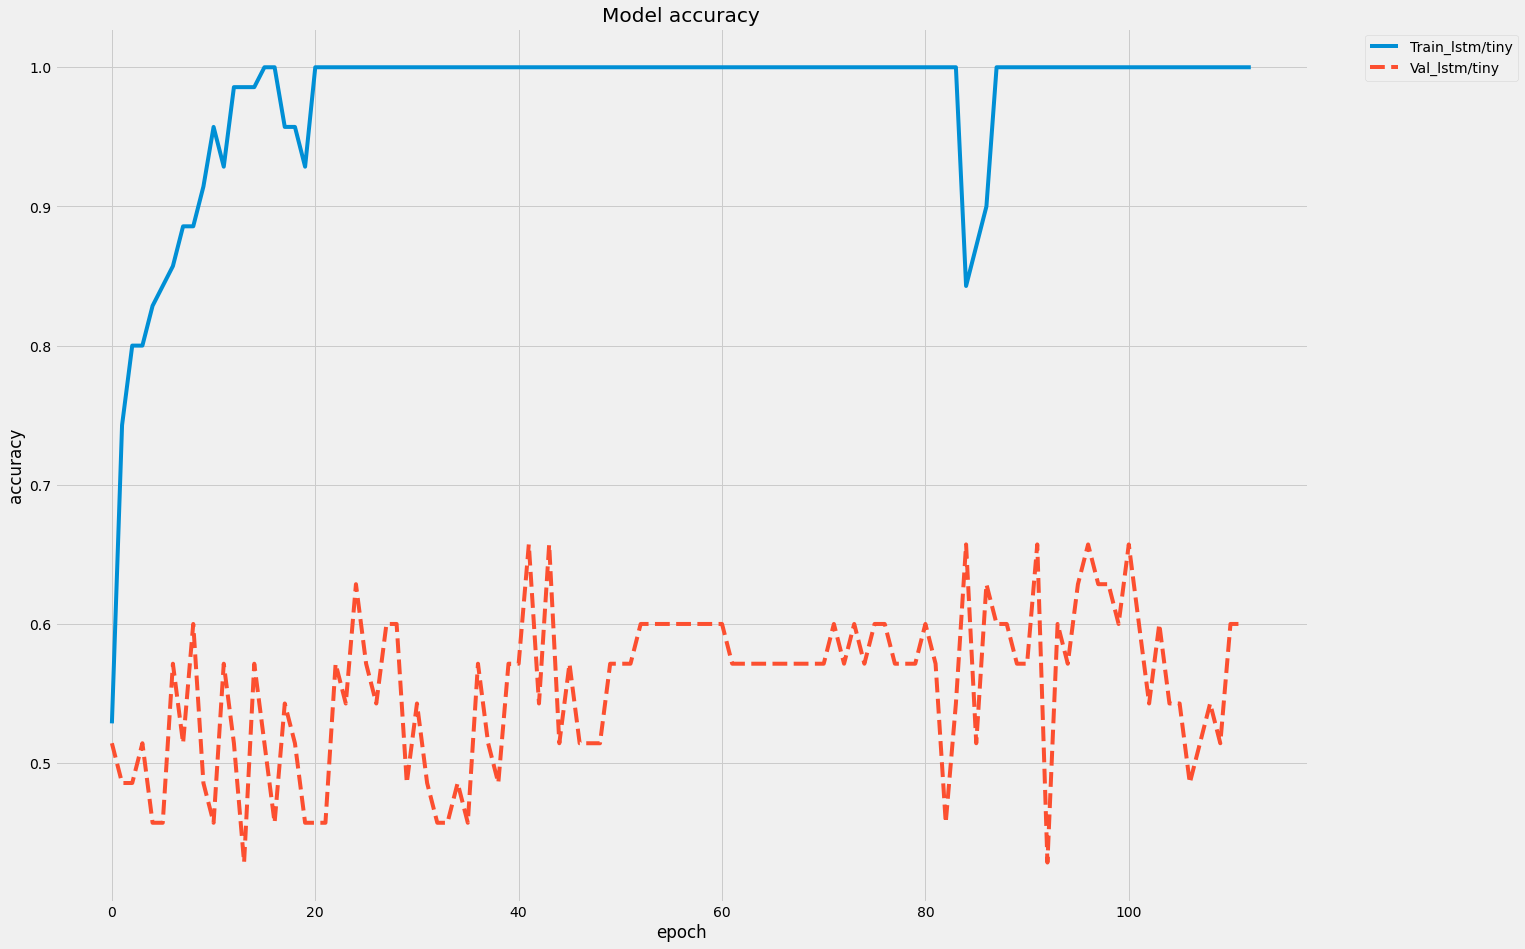

In [41]:
plot_report(lstm_histories, 'accuracy')

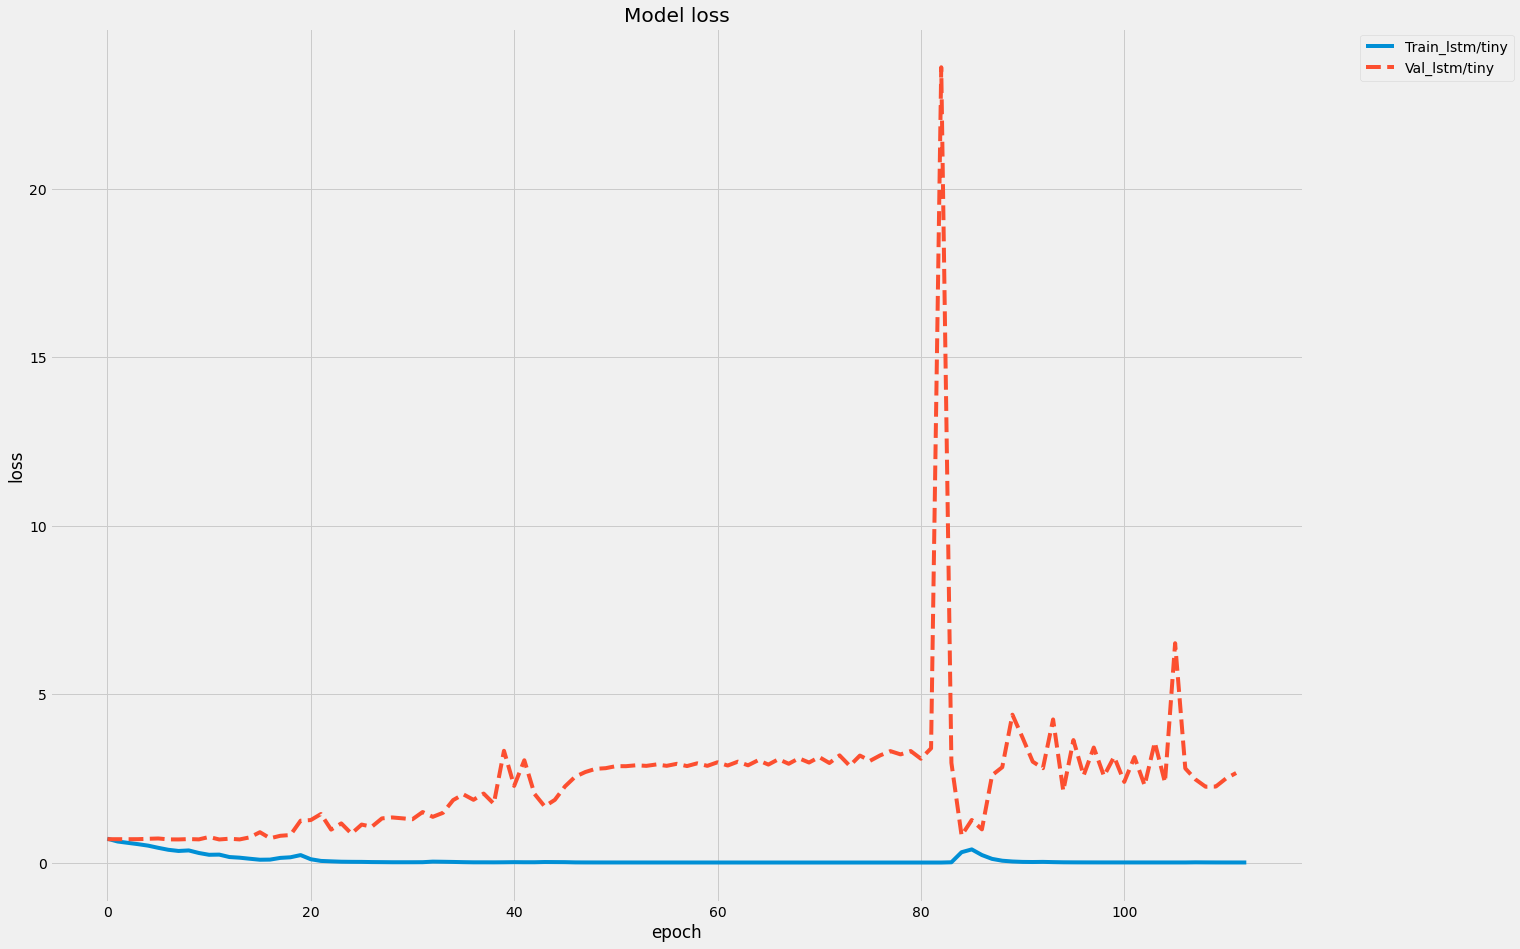

In [42]:
plot_report(lstm_histories, 'loss')

In [43]:
lstm_small_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True,
                        kernel_regularizer=regularizers.l2(lr2),
                         input_shape=[X.shape[1],X.shape[2],]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/small'] = compile_and_fit(lstm_small_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                                        lr=1e-4,
#                                                                        multiplier=10),
                                               name="lstm/small")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/small'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/small'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 158, 128)          80384     
                                                                 
 batch_normalization (BatchN  (None, 158, 128)         512       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0

Epoch 48/1000
18/18 [==============================] - 0s 12ms/step - loss: 0.0287 - accuracy: 1.0000 - val_loss: 1.5559 - val_accuracy: 0.6571
Epoch 49/1000
18/18 [==============================] - 0s 13ms/step - loss: 0.0241 - accuracy: 1.0000 - val_loss: 1.5757 - val_accuracy: 0.6286
Epoch 50/1000
18/18 [==============================] - 0s 13ms/step - loss: 0.0267 - accuracy: 1.0000 - val_loss: 1.6944 - val_accuracy: 0.6000
Epoch 51/1000
18/18 [==============================] - 0s 13ms/step - loss: 0.0280 - accuracy: 1.0000 - val_loss: 1.9730 - val_accuracy: 0.6286
Epoch 52/1000
18/18 [==============================] - 0s 13ms/step - loss: 0.0244 - accuracy: 1.0000 - val_loss: 1.9907 - val_accuracy: 0.6286
Epoch 53/1000
18/18 [==============================] - 0s 13ms/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.8759 - val_accuracy: 0.6286
Epoch 54/1000
18/18 [==============================] - 0s 13ms/step - loss: 0.0255 - accuracy: 1.0000 - val_loss: 1.7782 - val_accuracy:

Epoch 105/1000
18/18 [==============================] - 0s 12ms/step - loss: 0.3312 - accuracy: 0.8429 - val_loss: 4.4012 - val_accuracy: 0.4571
Epoch 106/1000
18/18 [==============================] - 0s 12ms/step - loss: 0.2967 - accuracy: 0.9000 - val_loss: 5.2679 - val_accuracy: 0.4571
Epoch 107/1000
18/18 [==============================] - 0s 13ms/step - loss: 0.1166 - accuracy: 0.9857 - val_loss: 2.9740 - val_accuracy: 0.4286
Epoch 108/1000
18/18 [==============================] - 0s 13ms/step - loss: 0.1247 - accuracy: 0.9714 - val_loss: 1.9365 - val_accuracy: 0.4286
Epoch 109/1000
18/18 [==============================] - 0s 12ms/step - loss: 0.1502 - accuracy: 0.9429 - val_loss: 8.1954 - val_accuracy: 0.4571
Epoch 110/1000
18/18 [==============================] - 0s 12ms/step - loss: 0.1458 - accuracy: 0.9571 - val_loss: 5.1128 - val_accuracy: 0.4571
Epoch 111/1000
18/18 [==============================] - 0s 12ms/step - loss: 0.1181 - accuracy: 0.9857 - val_loss: 9.4115 - val_ac

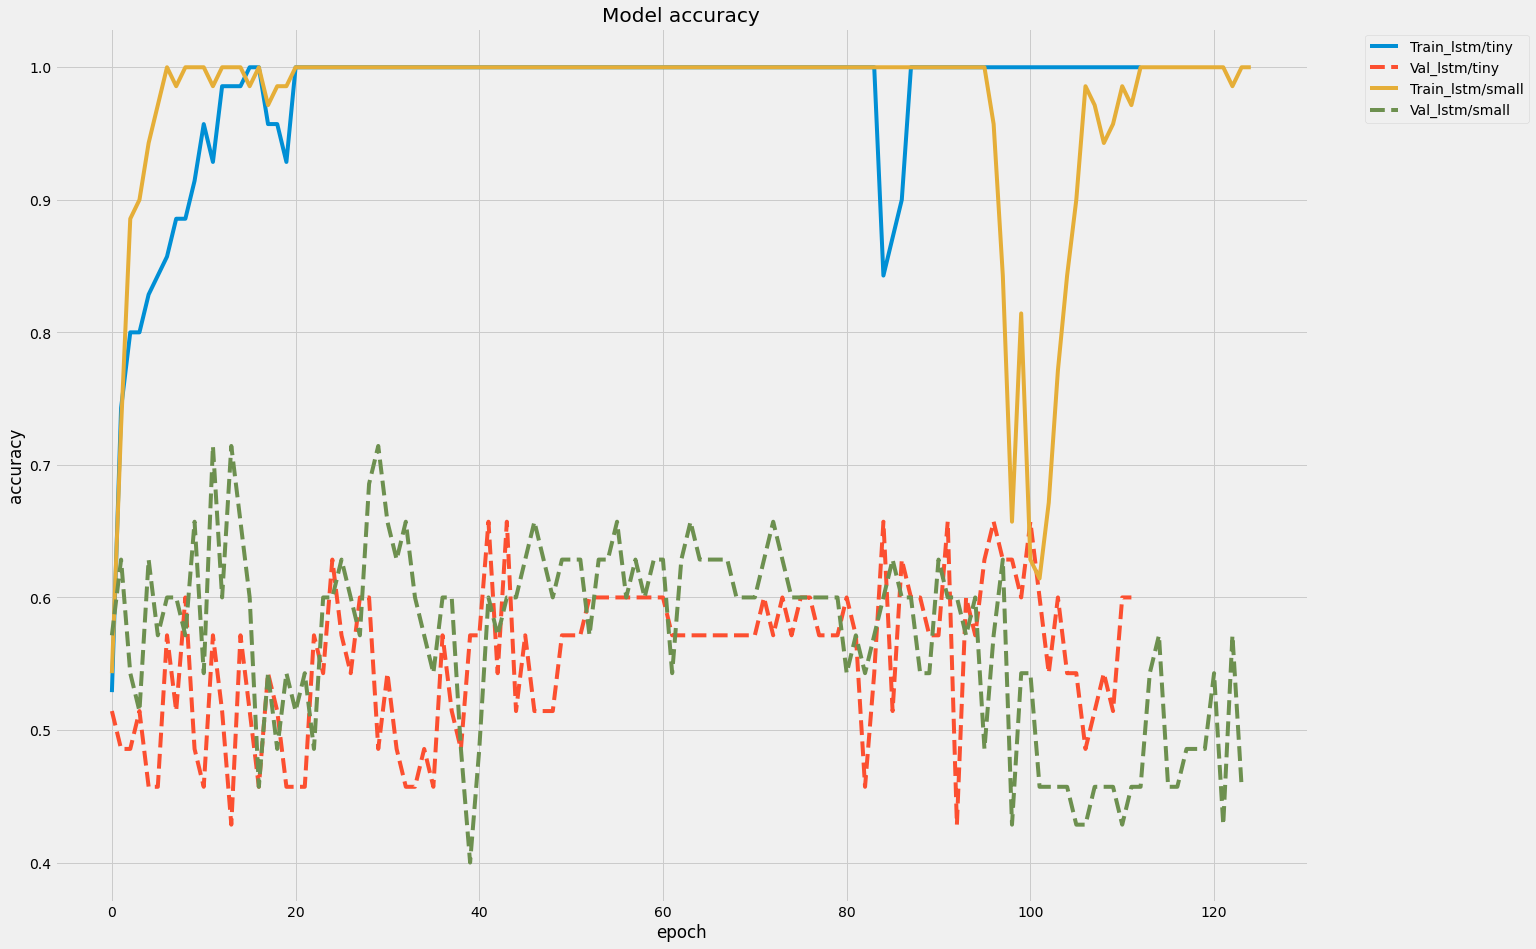

In [44]:
plot_report(lstm_histories, 'accuracy')

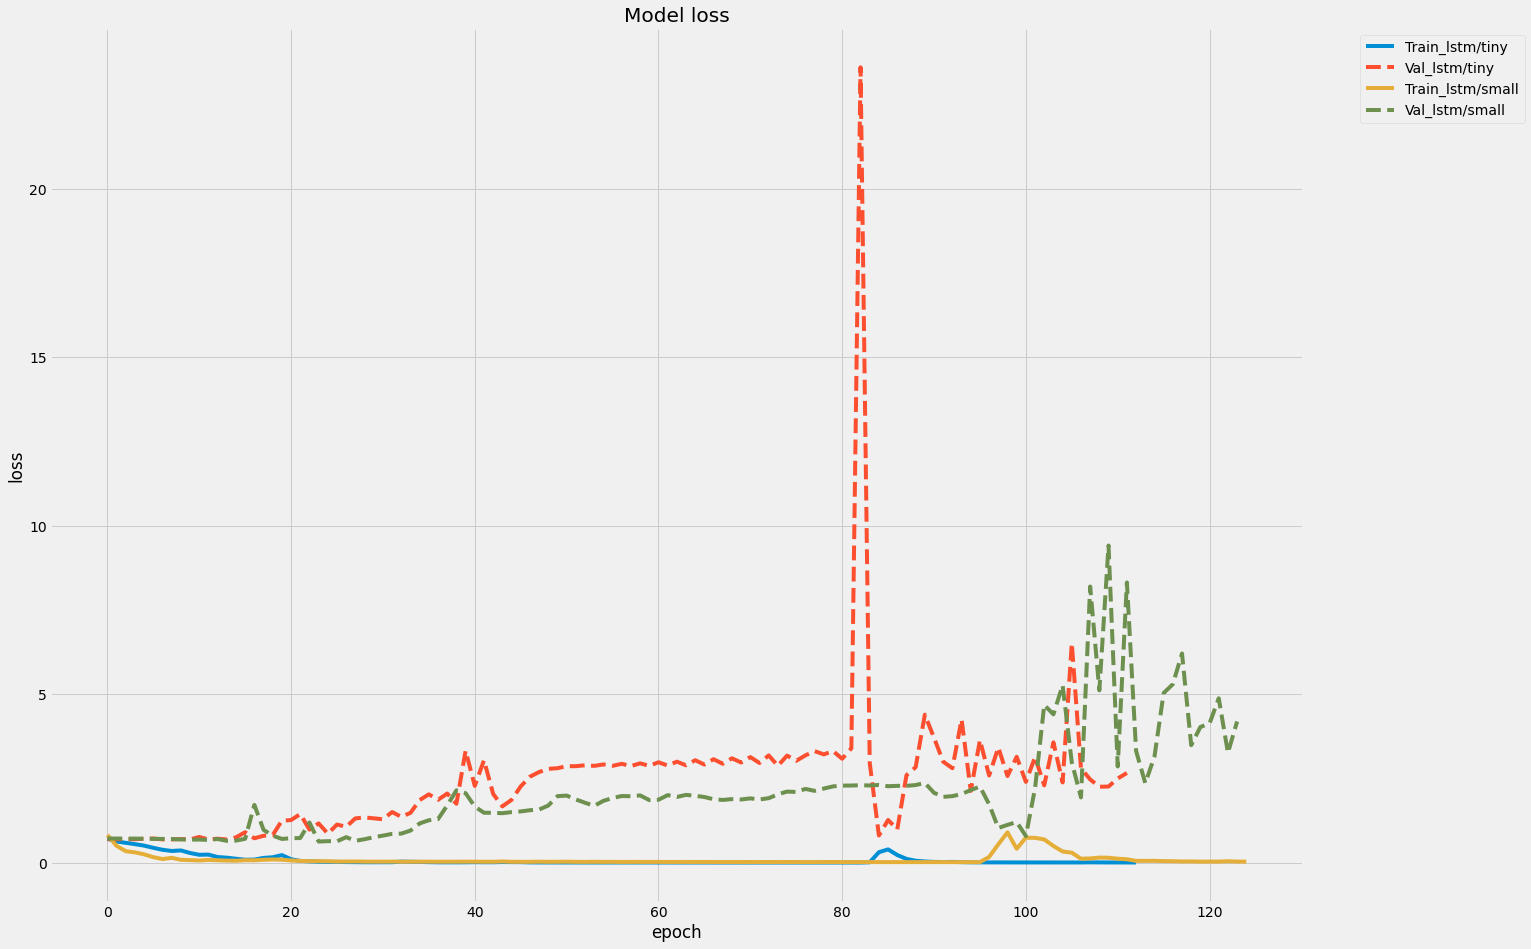

In [45]:
plot_report(lstm_histories, 'loss')

In [46]:
lstm_units=256
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_large_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True,
                        kernel_regularizer=regularizers.l2(lr2),
                         input_shape=[X.shape[1],X.shape[2],]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activ38ation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/large'] = compile_and_fit(lstm_large_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                lr=1e-4,
#                                                multiplier=10), 
                                                name="lstm/large")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/large'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/large'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 158, 256)          291840    
                                                                 
 batch_normalization (BatchN  (None, 158, 256)         1024      
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 batch_normalization_2 (Batc  (None, 128)              5

Epoch 96/1000
18/18 [==============================] - 0s 15ms/step - loss: 0.1250 - accuracy: 0.9714 - val_loss: 1.2360 - val_accuracy: 0.5714
Epoch 97/1000
18/18 [==============================] - 0s 15ms/step - loss: 0.1060 - accuracy: 0.9714 - val_loss: 1.3941 - val_accuracy: 0.5143
Epoch 98/1000
18/18 [==============================] - 0s 15ms/step - loss: 0.1125 - accuracy: 0.9857 - val_loss: 1.2150 - val_accuracy: 0.6286
Epoch 99/1000
18/18 [==============================] - 0s 15ms/step - loss: 0.1365 - accuracy: 0.9571 - val_loss: 1.3951 - val_accuracy: 0.5429
Epoch 100/1000
18/18 [==============================] - 0s 15ms/step - loss: 0.1290 - accuracy: 0.9857 - val_loss: 1.7216 - val_accuracy: 0.4571
Epoch 101/1000
18/18 [==============================] - 0s 14ms/step - loss: 0.1248 - accuracy: 0.9857 - val_loss: 1.7026 - val_accuracy: 0.4857
Epoch 102/1000
18/18 [==============================] - 0s 14ms/step - loss: 0.1218 - accuracy: 0.9857 - val_loss: 1.9903 - val_accura

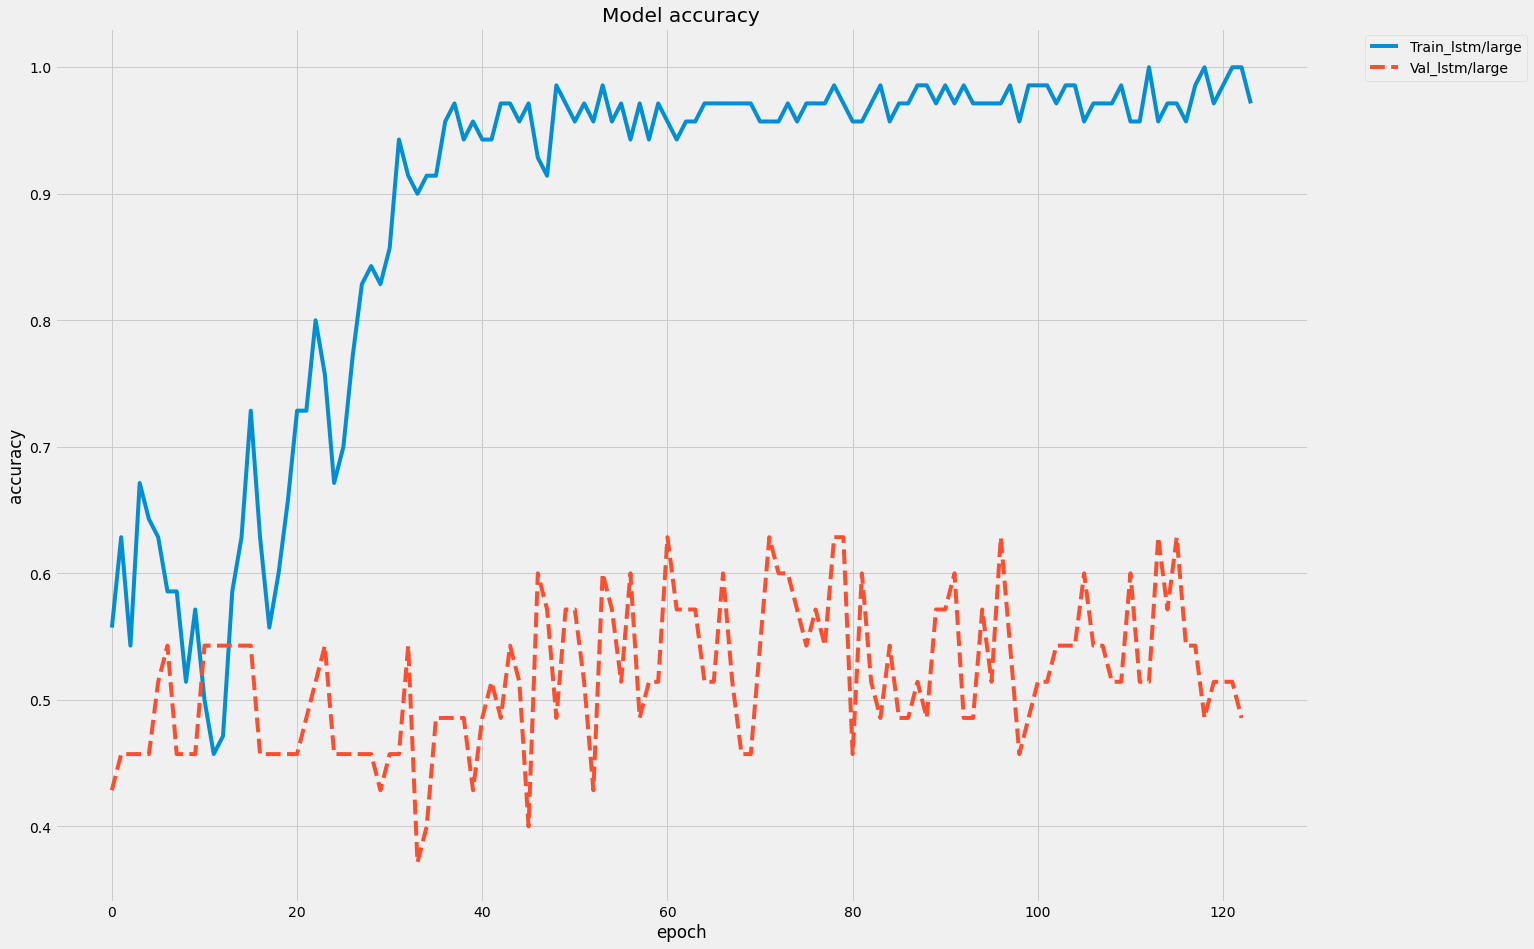

In [47]:
plot_report({'lstm/large':lstm_histories['lstm/large']}, 'accuracy')

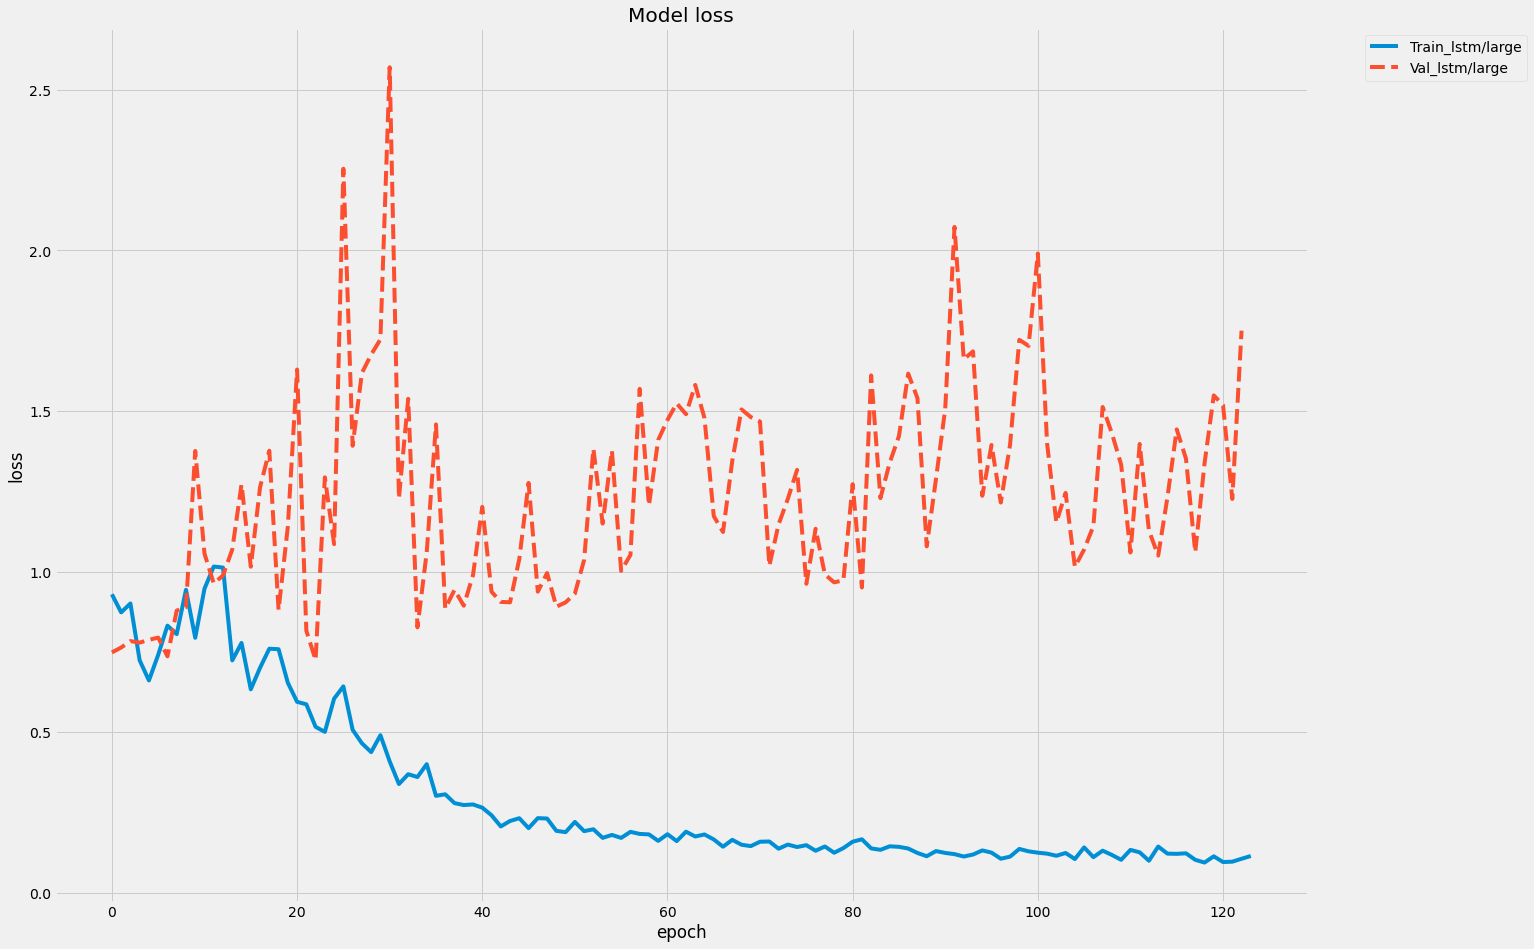

In [48]:
plot_report({'lstm/large':lstm_histories['lstm/large']}, 'loss')